# Дипломный проект. Телеком. Кузнецов Сергей. DS15+ #

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

#### Описание услуг ####

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

#### Описание данных ####

**Данные хранятся в базе данных PostgreSQL.
Она состоит из нескольких таблиц:**

- contract — информация о договорах;
- personal — персональные данные клиентов;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.

**Таблица telecom.contract**
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

**Таблица personal**
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

**Таблица telecom.internet**
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

**Таблица telecom.phone**
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

**Информация о договорах актуальна на 1 февраля 2020.**

## Предварительная подготовка ##

Соберу все импорты библиотек в ячейке ниже. Чтобы всё было удобно. Ну и подключимся к базе и загрузим все датасеты, с которыми нам дальше работать.

In [1]:
#Импортирование библиотек
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, auc, make_scorer, _plot, confusion_matrix
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from catboost import CatBoostClassifier, Pool

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tqdm import tqdm

In [2]:
#константы
RANDOM_STATE = 18092023

In [3]:
#настройки вывода
pd.set_option('display.max_columns', None)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
#подключение к базе данных
db_config = {
    'user': 'praktikum_student',                            # имя пользователя
    'password': 'Sdf4$2;d-d30pp',                                # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',    # хост
    'port': 6432,                                           # порт подключения
    'database': 'data-science-final'                              # название базы данных
}

db_uri = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

In [5]:
engine = create_engine(db_uri)

def load(table_name):
    """
    The load function loads a table from the database into a pandas dataframe.
    Args:  table_name (str): The name of the table to load.
    :param table_name: Specify the name of the table to be loaded
    :return: A message with the table name and a dataframe
    """
    try:
        df = pd.read_sql(f"SELECT * FROM telecom.{table_name}", engine)
        print(f"Таблица {table_name} успешно загружена")
        return df
    except Exception as e:
        print(f"Не удалось загрузить таблицу {table_name}: {str(e)}")

contract = load('contract')
phone = load('phone')
internet = load('internet')
personal = load('personal')

Таблица contract успешно загружена
Таблица phone успешно загружена
Таблица internet успешно загружена
Таблица personal успешно загружена


Все таблицы загружены в датафреймы Pandas. Переходим к изучению.

# Исследовательский анализ данных #

Взглянем на каждый датафрейм по отдельности.

In [6]:
#функция для комплексного исследовательского анализа
#здесь и далее все docstrings написаны с помощью плагина Trelent, просто в качестве тренировки
def analyze(df):
    """
    The analyze function takes a dataframe as input and prints out the number of rows and columns,
    the first 5 rows, summary statistics for each column, and information about the data types in each column.
    :param df: Pass the dataframe to the function
    :return: The number of columns, the number of rows,
    """
    rows_count, columns_count = df.shape
    print('Количество столбцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()
    return None

### Датасет Contract ###

In [7]:
analyze(contract)

Количество столбцов: 8
Количество строк: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Некоторые проблемы видны сразу, о них в выводах. Но вот название колонок давайте приведём к нужному регистру прямо сейчас.

In [8]:
column_mapping = {
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges'
}

# Переименуйте колонки в датасете
contract.rename(columns=column_mapping, inplace=True)

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           1869 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Так-то будет получше.

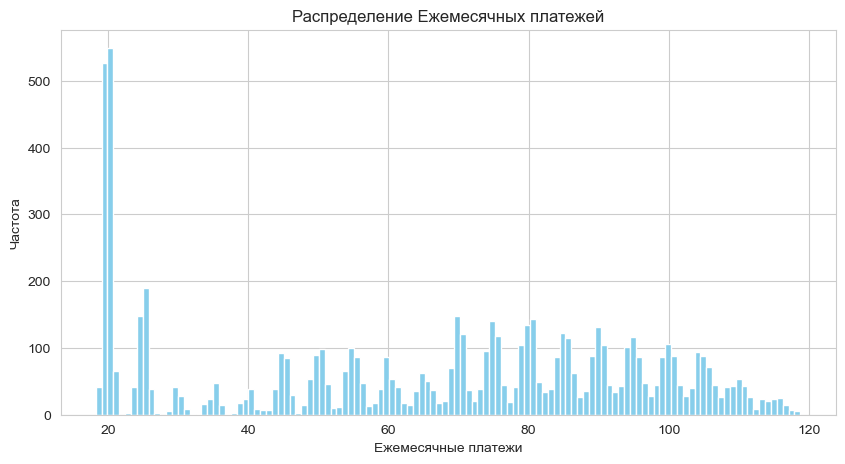

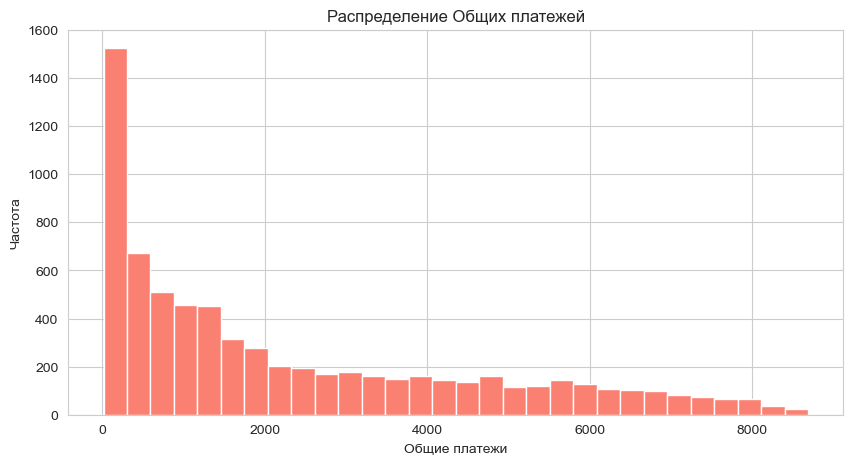

In [10]:
# Гистограмма для MonthlyCharges
plt.figure(figsize=(10, 5))
plt.hist(contract['monthly_charges'], bins=120, color='skyblue')
plt.title('Распределение Ежемесячных платежей')
plt.xlabel('Ежемесячные платежи')
plt.ylabel('Частота')
plt.show()

# Гистограмма для TotalCharges
plt.figure(figsize=(10, 5))
plt.hist(contract['total_charges'], bins=30, color='salmon')
plt.title('Распределение Общих платежей')
plt.xlabel('Общие платежи')
plt.ylabel('Частота')
plt.show()

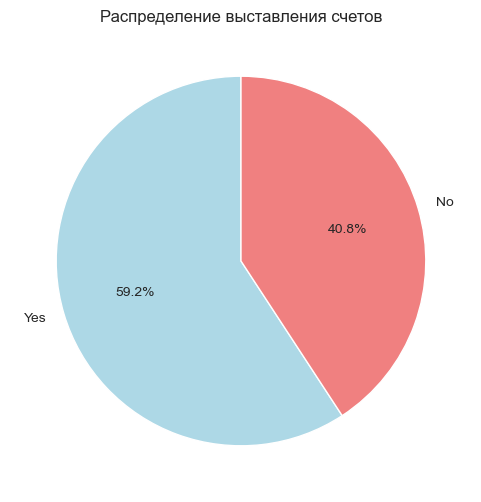

In [11]:
# Подсчет количества бумажных и цифровых выставлений счетов
billing_counts = contract['paperless_billing'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(billing_counts, labels=billing_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Распределение выставления счетов')
plt.show()

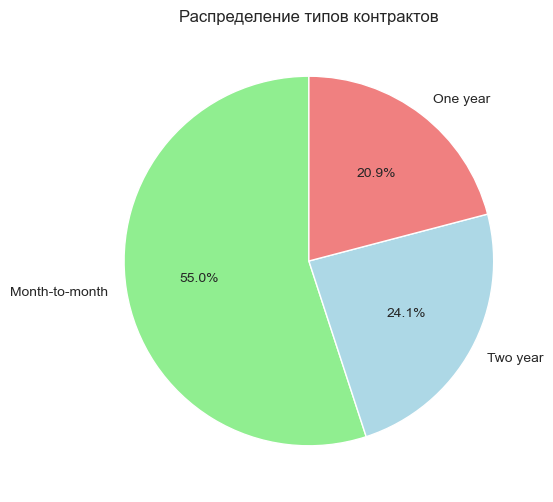

In [12]:
# Подсчет количества каждого типа контракта
contract_counts = contract['type'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(contract_counts, labels=contract_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title('Распределение типов контрактов')
plt.show()

#### Выводы о таблице Contract ####

- В данных есть пропуски, их надо будет как-то заполнить или очистить
- begin_date и end_date надо перевести в формат даты
- В end_date у нас есть None, это как раз целевой признак. Значит, пользователь не отказался от использования услуг
- TotalCharges надо перевести в числовой тип
- К PaymentMethod, Type и PaperlessBilling надо применить One Hot Encoding
- Большинство пользователей платит очень мало, что в месяц, что суммарно
- Больше половины оплачивают счета электронно
- Месячные оплаты составляют больше половины, годовые и двухлетние контракты около 20%.

### Датасет Personal ###

In [13]:
analyze(personal)

Количество столбцов: 5
Количество строк: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


О, тут хотя бы видимых пустот нет. Понятно, что внутри всякое ещё может быть, но уже лучше, чем с контрактами дела. Переименуем колонки и будет вообще хорошо.

In [14]:
column_mapping = {
    'customerID': 'customer_id',
    'gender': 'gender',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents'
}

# Переименуйте колонки в датасете
personal.rename(columns=column_mapping, inplace=True)

In [15]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


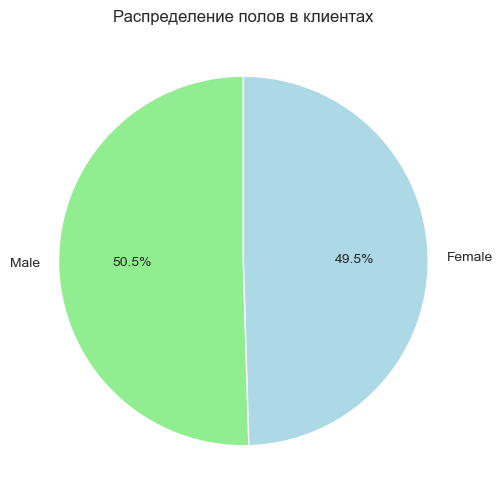

In [16]:
# Подсчет количества каждого пола
gender_counts = personal['gender'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title('Распределение полов в клиентах')
plt.show()

Вот это баланс! 50/50 мужчин и женщин.

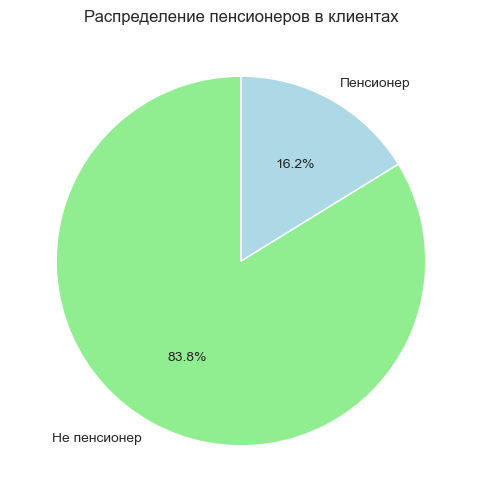

In [17]:
# Подсчет количества пенсионеров
senior_counts = personal['senior_citizen'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(senior_counts, labels=['Не пенсионер','Пенсионер'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title('Распределение пенсионеров в клиентах')
plt.show()

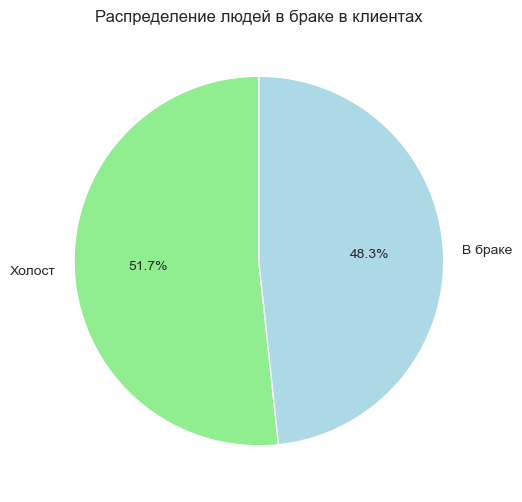

In [18]:
# Подсчет количества людей в браке
partner_counts = personal['partner'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(partner_counts, labels=['Холост','В браке'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title('Распределение людей в браке в клиентах')
plt.show()

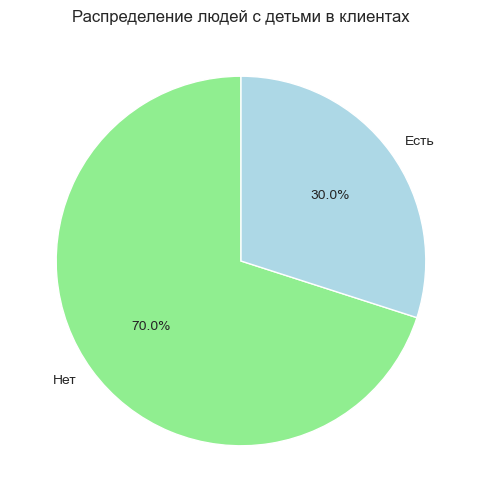

In [19]:
# Подсчет количества людей с детьми
dependents_counts = personal['dependents'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(6, 6))
plt.pie(dependents_counts, labels=['Нет','Есть'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title('Распределение людей с детьми в клиентах')
plt.show()

#### Выводы: ####
- В данных нет пропусков
- К gender, partner, dependents и senior надо применить One Hot Encoding

### Датасет Phone ###

In [20]:
analyze(phone)

Количество столбцов: 2
Количество строк: 6362


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


,c1,c2
count,6362,6362
unique,6362,3
top,customerID,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Очень красиво, но ничего не понятно. Исправим названия колонок.

In [21]:
column_mapping = {
    'c1': 'customer_id',
    'c2': 'multiple_lines'
}

# Переименуйте колонки в датасете
phone.rename(columns=column_mapping, inplace=True)

phone.drop(0, inplace=True)

In [22]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


#### Выводы: ####
- В данных нет пропусков
- К multiple_lines надо применить One Hot Encoding

### Датасет Internet ###

In [23]:
analyze(internet)

Количество столбцов: 8
Количество строк: 5518


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


,c1,c2,c3,c4,c5,c6,c7,c8
count,5518,5518,5518,5518,5518,5518,5518,5518
unique,5518,3,3,3,3,3,3,3
top,customerID,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


In [24]:
internet.columns = internet.iloc[0]
internet = internet[1:]

In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [26]:
column_mapping = {
    'customerID': 'customer_id',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport' : 'tech_support',
    'StreamingTV' : 'streaming_tv',
    'StreamingMovies' : 'streaming_movies'
}

# Переименуйте колонки в датасете
internet.rename(columns=column_mapping, inplace=True)

In [27]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


#### Выводы: ####
- В данных нет пропусков
- Ко всем колонкам придётся применять One Hot Encoding, они категориальные

## Предварительные выводы ##
- Данных не очень много, поэтому удалить проблемные не получится
- Есть проблемы с пустотами, а также очень много категориальных колонок
- На первый взгляд каких-то особых аномалий нет, но это мы выявим в следующем блоке.

# Предобработка данных #

Начнём с самого проблемного и самого интересного датасета Contract.

## Предварительня обработка Contract ##

In [28]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


По задаче мы должны будем спрогнозировать отток. То есть, уйдёт клиент или нет. Но наш целевой признак сейчас вписан в колонку end_date. Заведем отдельный столбец 'gone', куда очень просто запишем: если в end_date None, то пишем 0 (то есть, не ушёл), если нет, то 1 (ушёл). Ну и будем в дальнейшем решать задачу классификации.

In [29]:
contract['gone'] = contract['end_date'].notna().astype(int)

In [30]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


Теперь с чистой совестью мы можем заполнить пустоты в данных end_date. Но минуточку, не медианой же? Нет, т.к. у нас есть дата 01 февраля 2020 года как дата, на которую получали данные, то её мы и вставим. Тогда мы сможем ещё одну интересную метрику выявить - количество дней, которое человек был абонентом (или является до сих пор). Ну и переведем уже даты в формат дат.

In [31]:
contract['end_date'].fillna("2020-02-01", inplace=True)

In [32]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gone               7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


In [33]:
contract['total_days'] = (contract['end_date'] - contract['begin_date']).dt.days

In [34]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone,total_days
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,479
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,279


Посмотрим, что у нас с пропусками. Наверняка же где-то есть.

In [35]:
print(contract.isna().sum())

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
gone                  0
total_days            0
dtype: int64


Ага, замечательно. 11 пропусков. В целом, можно и удалить. Но глянем, что там за пропуски такие.

In [36]:
contract[contract['total_charges'].isnull()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone,total_days
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
10,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
11,2775-SEFEE,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),61.90,NaN,0,0
4408,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
5160,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0


Да, так наглядно видно, что это те, у кого контракт только начался 1 февраля 2020 года. А значит, это новые пользователи. Странно, что у них не посчитаны общие расходы. Но в данном случае они будут просто равны месячным (можно было бы и 0 поставить, но т.к. месячные нам известны и они являются абонентами меньше 1 дня, можем вписать им месячные, это будет корректнее с точки зрения здравого смысла).

In [37]:
contract.loc[contract['total_charges'].isna(), 'total_charges'] = contract['monthly_charges']

Ну вот теперь красота и никаких пустот. Проверим теперь, нет ли у нас дублей.

In [38]:
contract.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Length: 7043, dtype: bool

Явных нет. Глянем, что там с неявными. Вдруг где-то некорректно ввели данные.

In [39]:
contract['paperless_billing'].unique()

array(['Yes', 'No'], dtype=object)

In [40]:
contract['payment_method'].unique()

array(['Bank transfer (automatic)', 'Mailed check', 'Electronic check',
       'Credit card (automatic)'], dtype=object)

In [41]:
contract['type'].unique()

array(['Two year', 'Month-to-month', 'One year'], dtype=object)

Нет, смотрите-ка, всё хорошо. Взглянем на графики числовых колонок.

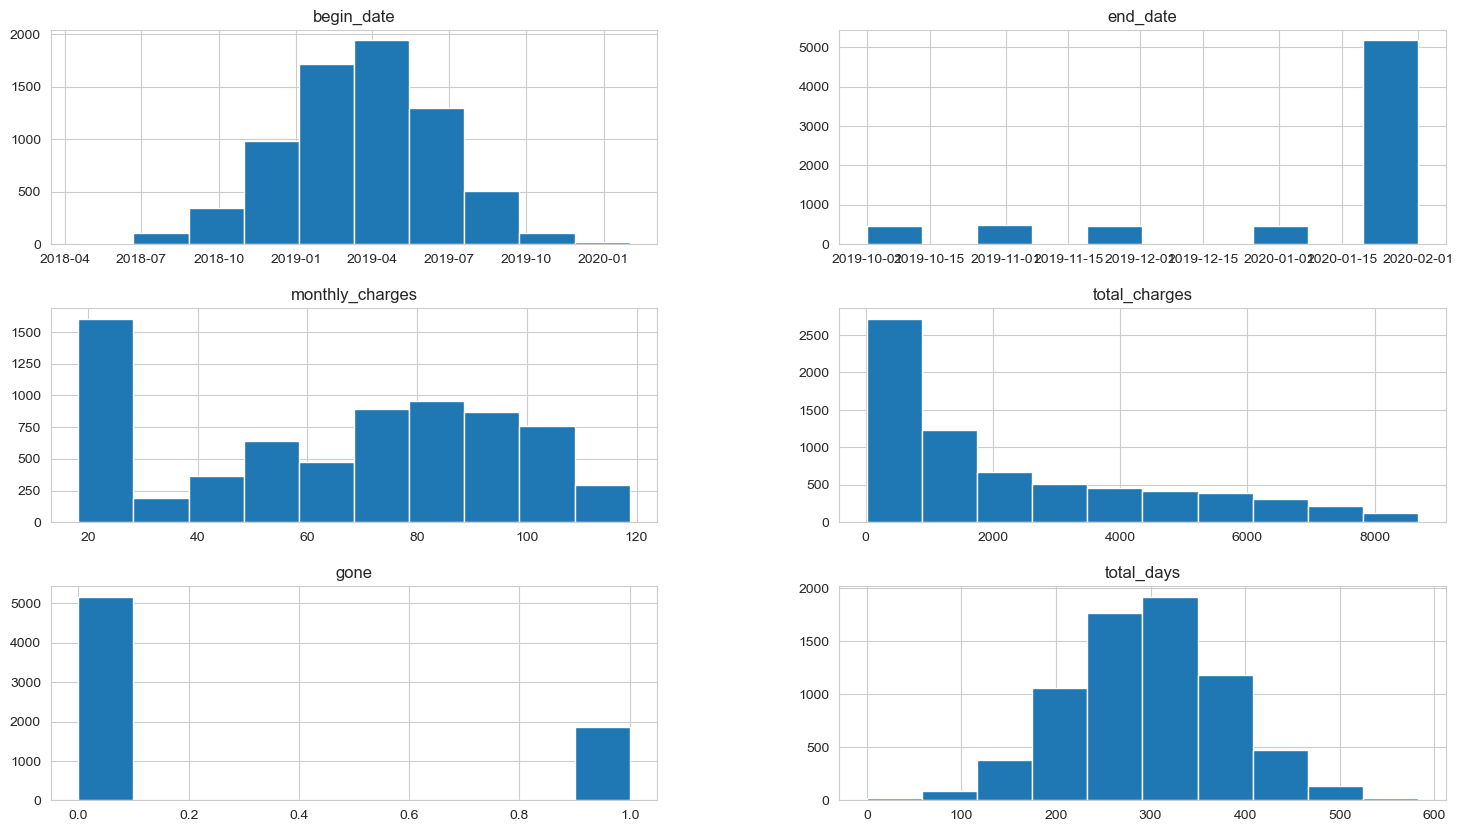

In [42]:
contract.hist(figsize=(18, 10))
plt.show()

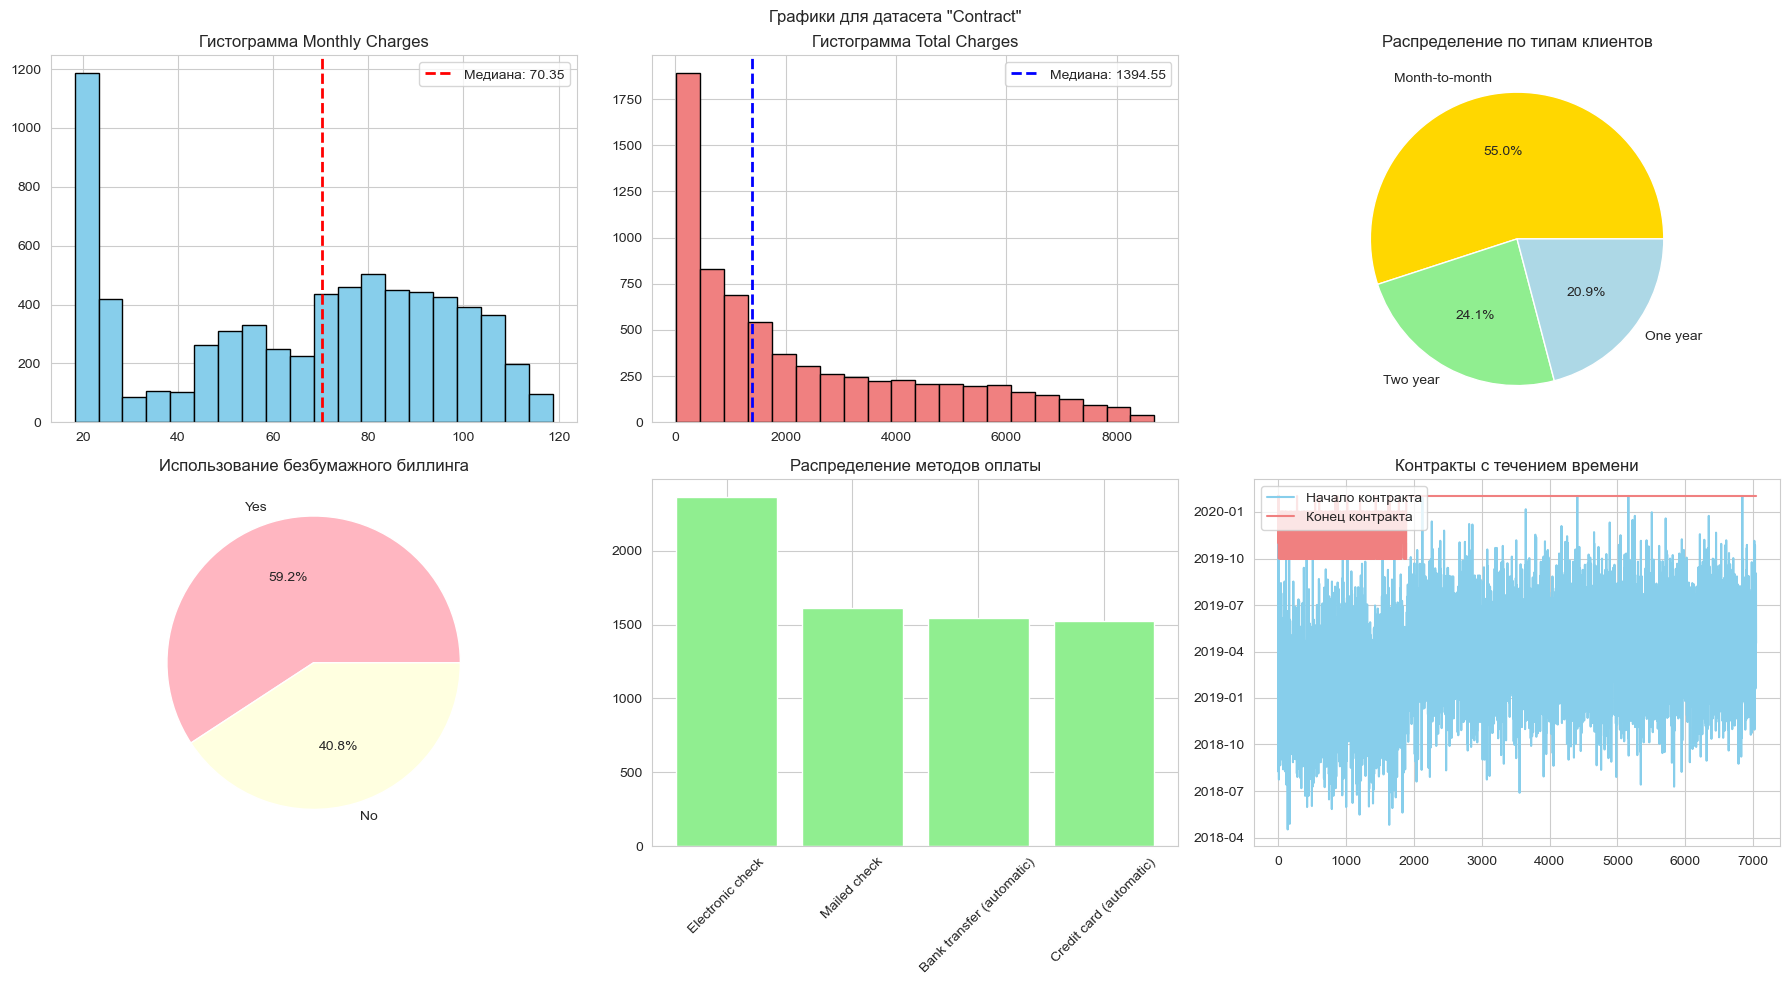

In [43]:
# Создаем поле с графиками
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Гистограмма для monthly_charges
axes[0, 0].hist(contract['monthly_charges'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Гистограмма Monthly Charges')
axes[0, 0].set_xlabel('Monthly Charges')
axes[0, 0].set_ylabel('Частота')

# Добавляем медианное значение
median_monthly_charges = contract['monthly_charges'].median()
axes[0, 0].axvline(median_monthly_charges, color='red', linestyle='dashed', linewidth=2, label=f'Медиана: {median_monthly_charges:.2f}')
axes[0, 0].legend()

# Гистограмма для total_charges
axes[0, 1].hist(contract['total_charges'], bins=20, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Гистограмма Total Charges')
axes[0, 1].set_xlabel('Total Charges')
axes[0, 1].set_ylabel('Частота')

# Добавляем медианное значение
median_total_charges = contract['total_charges'].median()
axes[0, 1].axvline(median_total_charges, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median_total_charges:.2f}')
axes[0, 1].legend()

# Круговая диаграмма для type
type_counts = contract['type'].value_counts()
axes[0, 2].pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=['gold', 'lightgreen', 'lightblue'])
axes[0, 2].set_title('Распределение по типам клиентов')

# Круговая диаграмма для paperless_billing
billing_counts = contract['paperless_billing'].value_counts()
axes[1, 0].pie(billing_counts, labels=billing_counts.index, autopct='%1.1f%%', colors=['lightpink', 'lightyellow'])
axes[1, 0].set_title('Использование безбумажного биллинга')

# Столбчатая диаграмма для payment_method
payment_counts = contract['payment_method'].value_counts()
axes[1, 1].bar(payment_counts.index, payment_counts, color='lightgreen')
axes[1, 1].set_title('Распределение методов оплаты')
axes[1, 1].tick_params(axis='x', rotation=45)

# График временных рядов для begin_date и end_date
axes[1, 2].plot(contract['begin_date'], label='Начало контракта', color='skyblue')
axes[1, 2].plot(contract['end_date'], label='Конец контракта', color='lightcoral')
axes[1, 2].set_title('Контракты с течением времени')
axes[1, 2].set_xlabel('Дата')
axes[1, 2].set_ylabel('Количество контрактов')
axes[1, 2].legend(loc='upper left')

# Включаем легенду для графика временных рядов
axes[1, 2].legend(loc='upper left')

# Убираем лишние подписи осей
for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')

# Добавляем общий заголовок
plt.suptitle('Графики для датасета "Contract"')

# Разрешаем автоматическую компоновку
plt.tight_layout()

# Показываем графики
plt.show()

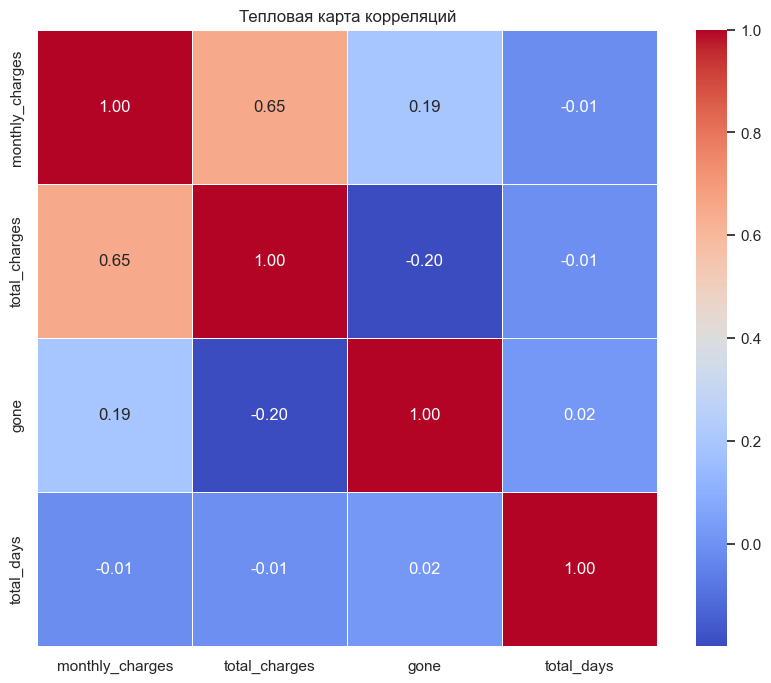

In [44]:
# Вычисляем корреляционную матрицу
corr_matrix = contract.corr(numeric_only=True)

# Настраиваем стиль
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.set_palette("husl")

# Строим тепловую карту корреляций
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Добавляем заголовок
plt.title('Тепловая карта корреляций')

# Показываем график
plt.show()

Ну, явных корреляций (кроме total charges и monthly charges, разумеется) у нас нет. Причём назвать total и monthly мультиколлинеарностью не получится, и удалить один из них, т.к. видимо кто-то докупал какие-то услуги и это отразилось в общих затратах, т.к. корреляция не 1. Остальные же признаки ничтожно мало коррелируют.

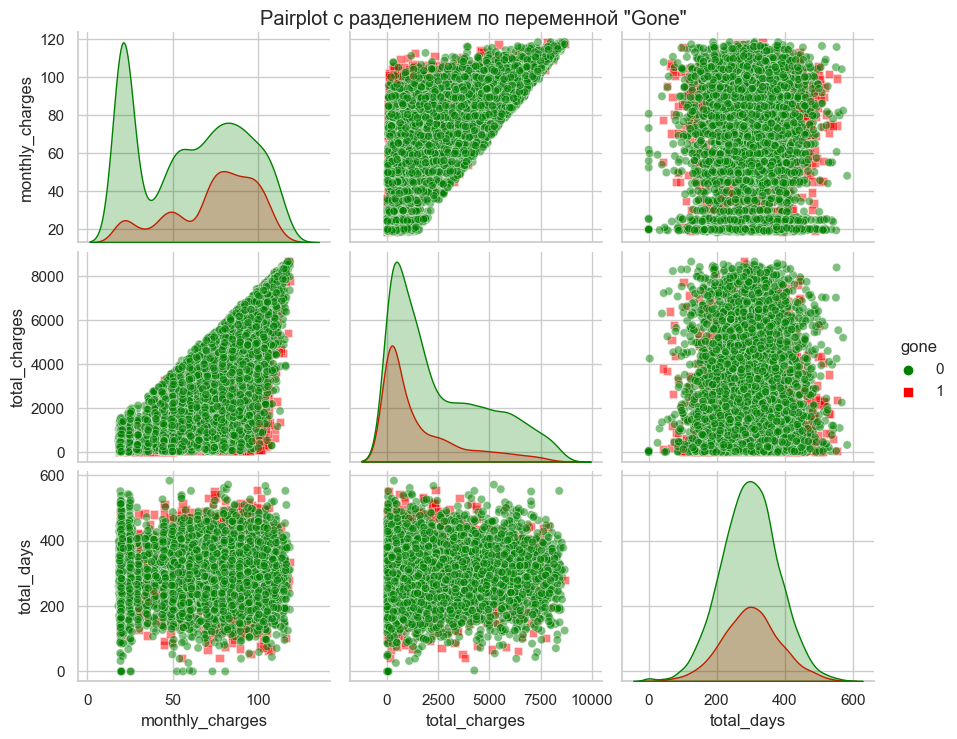

In [45]:
sns.set(style="whitegrid")
sns.set_palette("husl")

# Создаем pairplot с разделением по переменной "Gone" и установкой цветов
g = sns.pairplot(contract, hue="gone", diag_kind="kde", palette={0: 'green', 1: 'red'}, markers=["o", "s"], height=2.5, aspect=1.2, plot_kws={"alpha": 0.5})

# Перемещаем заголовок выше
plt.subplots_adjust(top=0.95)

# Добавляем заголовок
plt.suptitle('Pairplot с разделением по переменной "Gone"')

# Показываем график
plt.show()

Ну, тут мы тоже не видим каких-то явных зависимостей. Разве что те, у кого низкие месячные траты, с большей вероятностью остаются абонентами. Но вот на общих тратах эта зависимость уже не такая явная. Интересная, неоднозначная картина. Здорово, что у нас есть data science и мы всё сможем предсказать с помощью моделей и нейросетей. Потому что вот глазами тут явно выводы сделать корректно не получится.

Т.к. в других датафреймах у нас не было пропусков, можем смело объединить 4 датафрейма в один датасет и продолжить изучать уже его. Чтобы ничего не потерять, делаем left join, по полю customer_id, разумеется, оно у нас везде есть и это ключ.

## Объединение датафреймов ##

In [46]:
clients = contract \
    .merge(personal, how='left', on='customer_id') \
    .merge(internet, how='left', on='customer_id') \
    .merge(phone, how='left', on='customer_id')

In [47]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gone               7043 non-null   int64         
 9   total_days         7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

In [48]:
clients['customer_id'].is_unique

True

Всё, никаких дубликатов людей нет, все идентификаторы клиентов уникальные. Прекрасно. Установим ID клиента как идентификатор датасета, чтобы он нам не мешал в данных, но выполнял свою роль.

In [49]:
clients = clients.set_index('customer_id')

In [50]:
analyze(clients)

Количество столбцов: 21
Количество строк: 7043


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,0,0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,0,0,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,479,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,0,0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,279,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


,monthly_charges,total_charges,gone,total_days,senior_citizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.265370,297.378674,0.162147
std,30.090047,2266.730170,0.441561,83.868181,0.368612
min,18.250000,18.800000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,242.000000,0.000000
50%,70.350000,1394.550000,0.000000,298.000000,0.000000
75%,89.850000,3786.600000,1.000000,351.000000,0.000000
max,118.750000,8684.800000,1.000000,583.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gone               7043 non-null   int64         
 8   total_days         7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14

Так, у нас образовались пропуски в колонках услуг. Это означает, что услуга не подключена (ну или ошибка заполнения, но это мы никак предусмотреть не можем). Заполним пропуски словом No, чтобы затем можно было нормально закодировать.

In [51]:
for column in ('internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'):
    clients[column] = clients[column].fillna('No')

In [52]:
clients.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gone,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,0,0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,0,0,Male,0,No,Yes,No,No,No,No,No,No,No,No
3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,479,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,0,0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,279,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [53]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gone               7043 non-null   int64         
 8   total_days         7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14

Ну вот теперь красота. 7043 клиента и по всем всё есть. Посмотрим, вдруг ещё есть пустоты или образовались полные дубликаты.

In [54]:
clients.duplicated()

customer_id
4472-LVYGI    False
3115-CZMZD    False
3668-QPYBK    False
5709-LVOEQ    False
9237-HQITU    False
              ...  
2569-WGERO    False
6840-RESVB    False
2234-XADUH    False
4801-JZAZL    False
3186-AJIEK    False
Length: 7043, dtype: bool

In [55]:
clients.isnull().sum()

begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gone                 0
total_days           0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Пустот нет, дубликатов нет. Взглянем теперь на данные, вдруг есть аномалии какие-то.

## Поиск аномалий и выбросов ##

Вот и настало время разделить колонки датасета на категориальные и числовые. Возможно, от каких-то мы даже избавимся.

In [56]:
categorical_columns = [
    'type',
    'paperless_billing',
    'payment_method',
    'gender',
    'partner',
    'senior_citizen',
    'dependents',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'multiple_lines'
]

numeric_columns = [
    'begin_date',
    'end_date',
    'monthly_charges',
    'total_charges',
    'total_days'
]

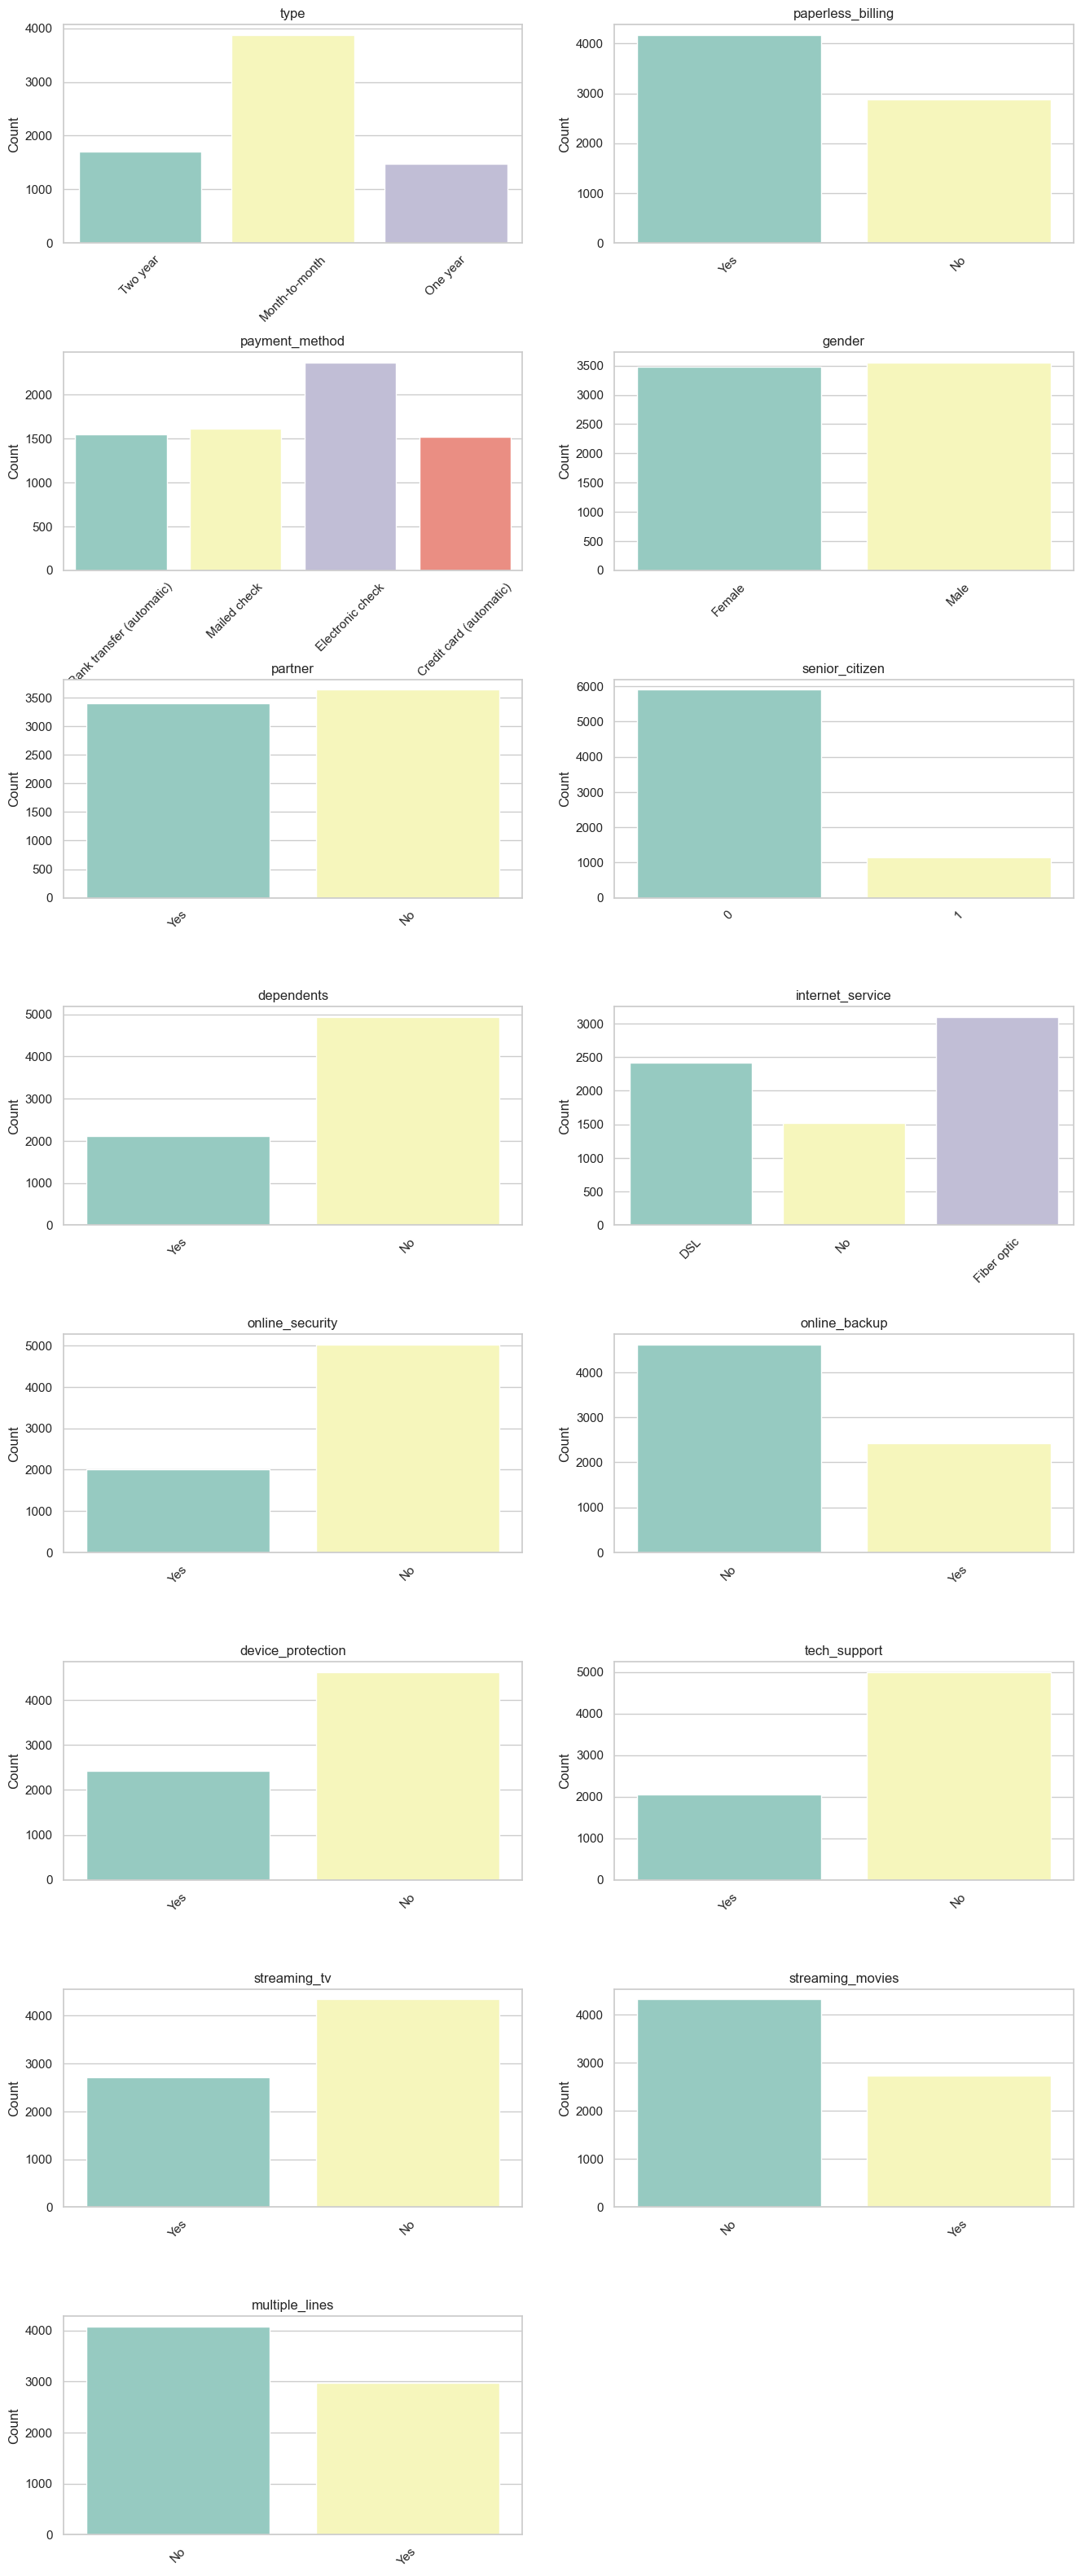

In [57]:
cols = 2
rows = int(np.ceil(len(categorical_columns) / cols))

# Создайте сетку для графиков
fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
fig.subplots_adjust(hspace=0.5)

# Итерируйтесь по столбцам и создавайте графики
for idx, column in enumerate(categorical_columns):
    ax = axes[idx // cols, idx % cols]

    # Создайте график с использованием Seaborn
    sns.countplot(data=clients, x=column, ax=ax, palette="Set3")

    # Добавьте заголовок и улучшите визуализацию
    ax.set_title(column)
    ax.set_xlabel(None)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

# Уберите лишние графики, если есть
for i in range(len(categorical_columns), rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.show()

Никаких лишних данных не видать. Да, баланса классов нет, но, в общем-то, это реальная статистика, так что нам его тут странно ожидать. Если будут проблемы - сделаем потом сэмплирование, например. Но глобально никаких проблем тут не вижу. Можем изучить числовые колонки теперь.

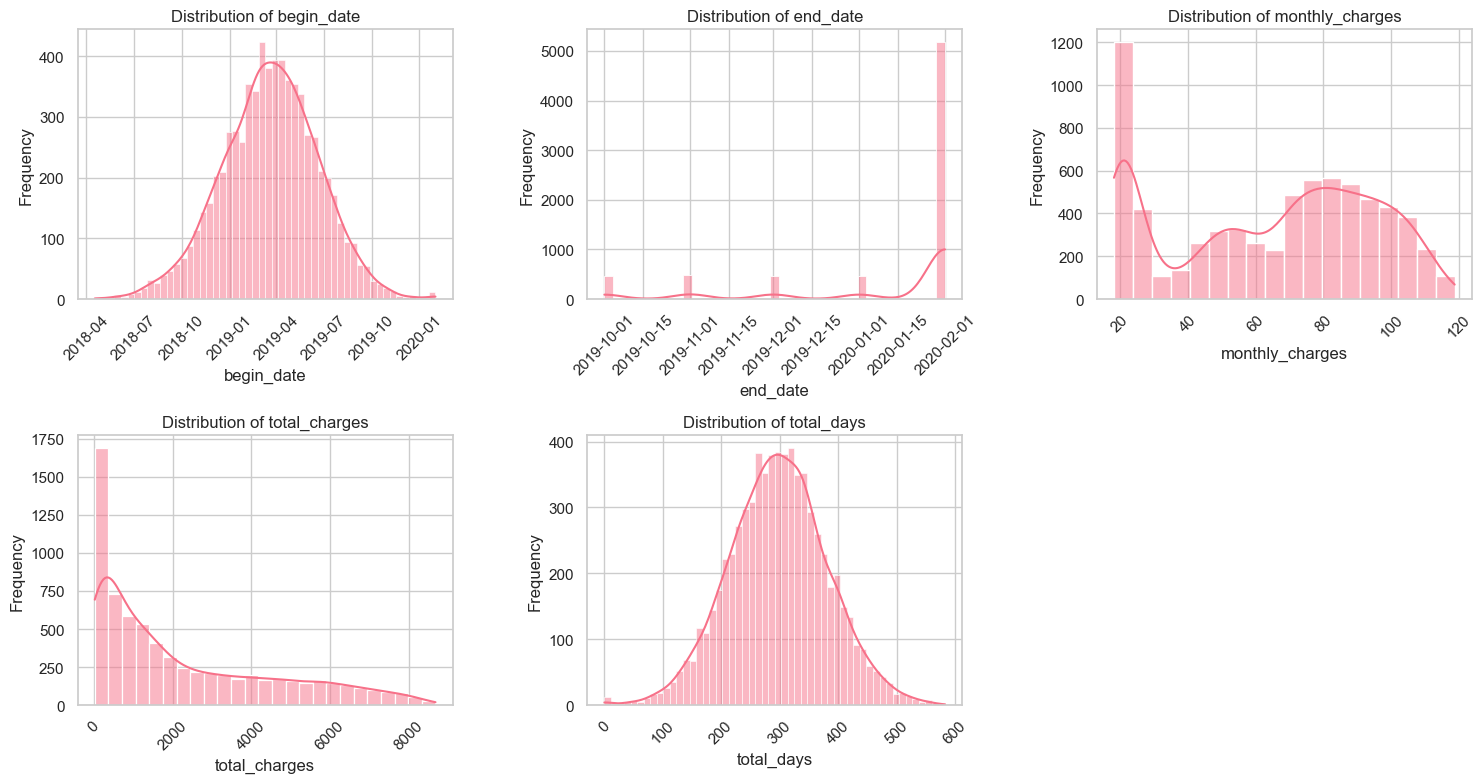

In [58]:
plt.figure(figsize=(15, 8))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(clients[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

plt.tight_layout(w_pad=3, h_pad=1)
plt.show()

Ну что ж, у нас в количестве дней, которые человек был абонентом и дате начала видно нормальное распределение. И это замечательно. В тратах за месяц и общих явно видно, что большинство платят минимум. И можно было бы сказать, что это новенькие абоненты, т.к. у нас 5 тысяч людей, у которых отмечена end_date на дату снятия данных, но напомню, что тут и те, кто до сих пор является абонентом, но нам нужно было заполнить пустоту в дате.

Забавно, что в monthly_charges видна бимодальность (несколько всплесков). Значит, в выборке есть несколько явных когорт. Возможно, выделим их и разметим на потенциально три сегмента - бедный, обычный и богатый клиент. Если будет необходимо.

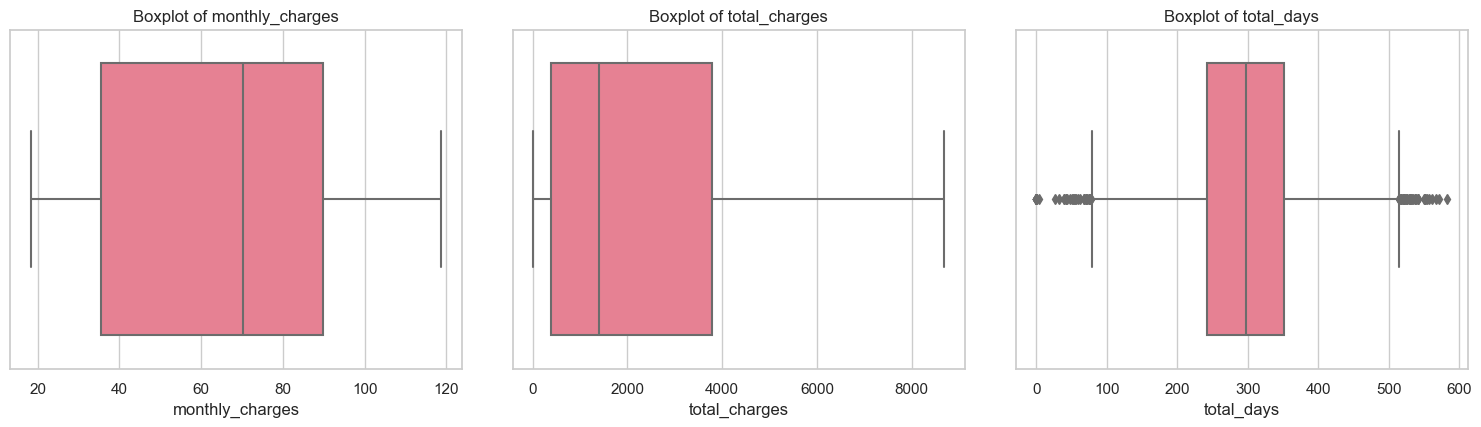

In [59]:
numeric_without_date = [
    'monthly_charges',
    'total_charges',
    'total_days'
]

plt.figure(figsize=(15, 8))
for i, column in enumerate(numeric_without_date, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=clients[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout(w_pad=3, h_pad=1)
plt.show()

Взглянем на категориальные признаки относительно целевого.

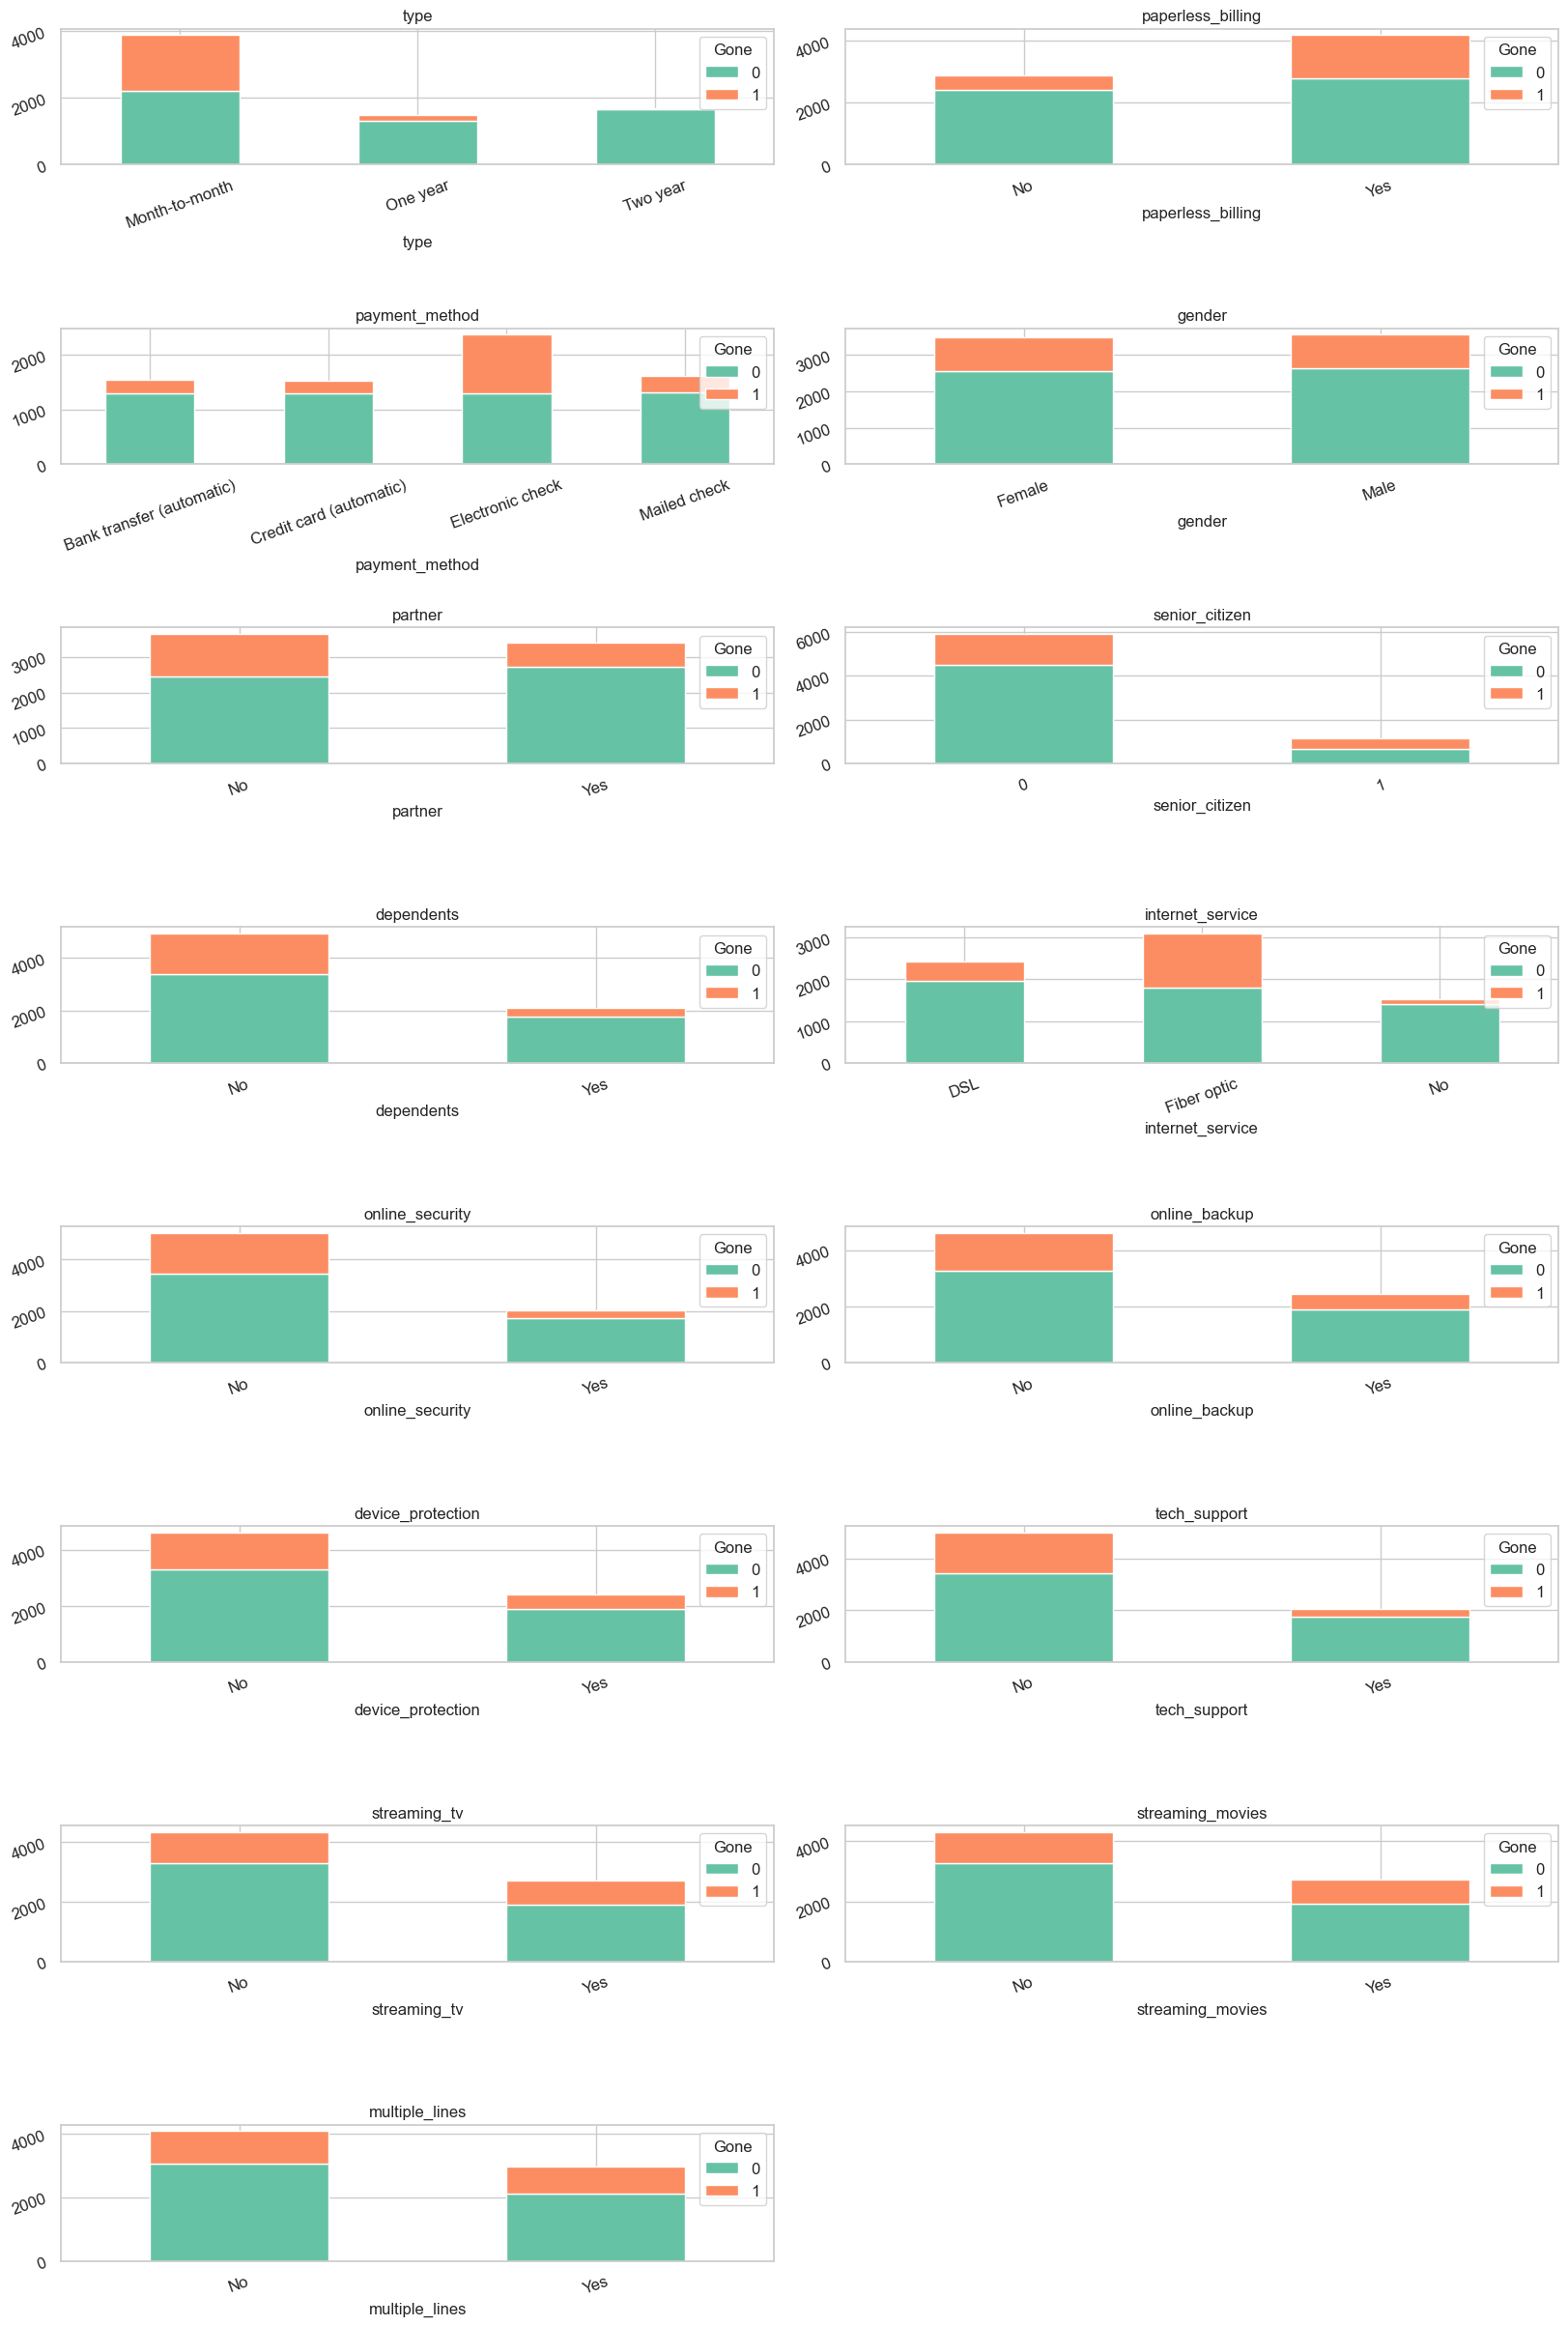

In [60]:
sns.set_palette("Set2")

cols = 2
rows = int(np.ceil(len(categorical_columns) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
plt.subplots_adjust(hspace=1.2, wspace=0.1)  # Увеличиваем расстояние между графиками

for idx, column in enumerate(categorical_columns):
    churn_grouped_df = clients.groupby([column, 'gone'])['gone'].count().unstack()

    ax = axes[idx // cols, idx % cols]

    churn_grouped_df.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(column)
    ax.legend(title='Gone', loc='upper right', fontsize='medium')  # Изменяем местоположение и размер легенды

    # Устанавливаем более крупный размер шрифта подписей на осях X и Y
    ax.tick_params(axis='both', labelrotation=20, labelsize='medium')

# Удаляем пустые подграфики, если они есть
for i in range(len(categorical_columns), rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.show()

In [61]:
def calculate_percentage(val, total):
    return f'{(val / total * 100):.2f}%'

for column in categorical_columns:
    table = clients.groupby([column, 'gone'])['gone'].count().unstack(fill_value=0)
    table['Total'] = table.sum(axis=1)
    table['% Not Gone'] = table[0] / table['Total'] * 100
    table['% Gone'] = table[1] / table['Total'] * 100

    # Находим максимальное отличие в процентах между классами в столбце "% Gone"
    max_diff = table['% Gone'].max() - table['% Gone'].min()

    # Добавляем стиль с подсветкой, если разница <= 10%
    styled_table = table[['% Not Gone', '% Gone']].style.applymap(
        lambda x: 'background-color: red' if max_diff <= 10 else '', subset=['% Gone']
    )

    print(f"Table for {column}:")
    display(styled_table)
    print()

Table for type:


gone,% Not Gone,% Gone
type,,
Month-to-month,57.290323,42.709677
One year,88.730482,11.269518
Two year,97.168142,2.831858



Table for paperless_billing:


gone,% Not Gone,% Gone
paperless_billing,,
No,83.669916,16.330084
Yes,66.434908,33.565092



Table for payment_method:


gone,% Not Gone,% Gone
payment_method,,
Bank transfer (automatic),83.290155,16.709845
Credit card (automatic),84.756899,15.243101
Electronic check,54.714588,45.285412
Mailed check,80.893300,19.106700



Table for gender:


gone,% Not Gone,% Gone
gender,,
Female,73.079128,26.920872
Male,73.839662,26.160338



Table for partner:


gone,% Not Gone,% Gone
partner,,
No,67.042021,32.957979
Yes,80.335097,19.664903



Table for senior_citizen:


gone,% Not Gone,% Gone
senior_citizen,,
0,76.393832,23.606168
1,58.318739,41.681261



Table for dependents:


gone,% Not Gone,% Gone
dependents,,
No,68.720860,31.279140
Yes,84.549763,15.450237



Table for internet_service:


gone,% Not Gone,% Gone
internet_service,,
DSL,81.040892,18.959108
Fiber optic,58.107235,41.892765
No,92.595020,7.404980



Table for online_security:


gone,% Not Gone,% Gone
online_security,,
No,68.670382,31.329618
Yes,85.388806,14.611194



Table for online_backup:


gone,% Not Gone,% Gone
online_backup,,
No,70.827915,29.172085
Yes,78.468506,21.531494



Table for device_protection:


gone,% Not Gone,% Gone
device_protection,,
No,71.348193,28.651807
Yes,77.497936,22.502064



Table for tech_support:


gone,% Not Gone,% Gone
tech_support,,
No,68.813763,31.186237
Yes,84.833659,15.166341



Table for streaming_tv:


gone,% Not Gone,% Gone
streaming_tv,,
No,75.668819,24.331181
Yes,69.929812,30.070188



Table for streaming_movies:


gone,% Not Gone,% Gone
streaming_movies,,
No,75.620506,24.379494
Yes,70.058565,29.941435



Table for multiple_lines:


gone,% Not Gone,% Gone
multiple_lines,,
No,74.975442,25.024558
Yes,71.390104,28.609896


Интересная картина: у нас есть признаки, распределение в которых почти равное. То есть, пользователь уходил, вне зависимости от того, какой у него пол или несколько линий (разница менее 10%). Эти признаки мы можем смело удалить позже из итогового датасета:
gender, multiple_lines, streaming_movies, streaming_tv, device_protection, online_backup

Наблюдения из оценки категориальных колонок по признаку ушёл клиент или нет:
- Среди ушедших большинство тех, кто платил ежемесячно. А вот те, кто на двухлетнем контракте, не уходили вообще (вероятно, у них и цена тарифа за месяц была ниже)
- Дополнительные услуги слабо влияют на отказы (возможно, их можно будет убрать из выборки для моделей)
- Пользователи с "Electronic check" для оплаты чаще отказываются от услуг, возможно в оплате онлайн есть какие-то неудобства
- Пенсионеры уходят чаще
- Если пользователь не пользуется интернетом, то вероятность отказа ниже. Возможно это связано с тем, что более пенсионеры не хотят разбираться в том, как сменить поставщика услуг

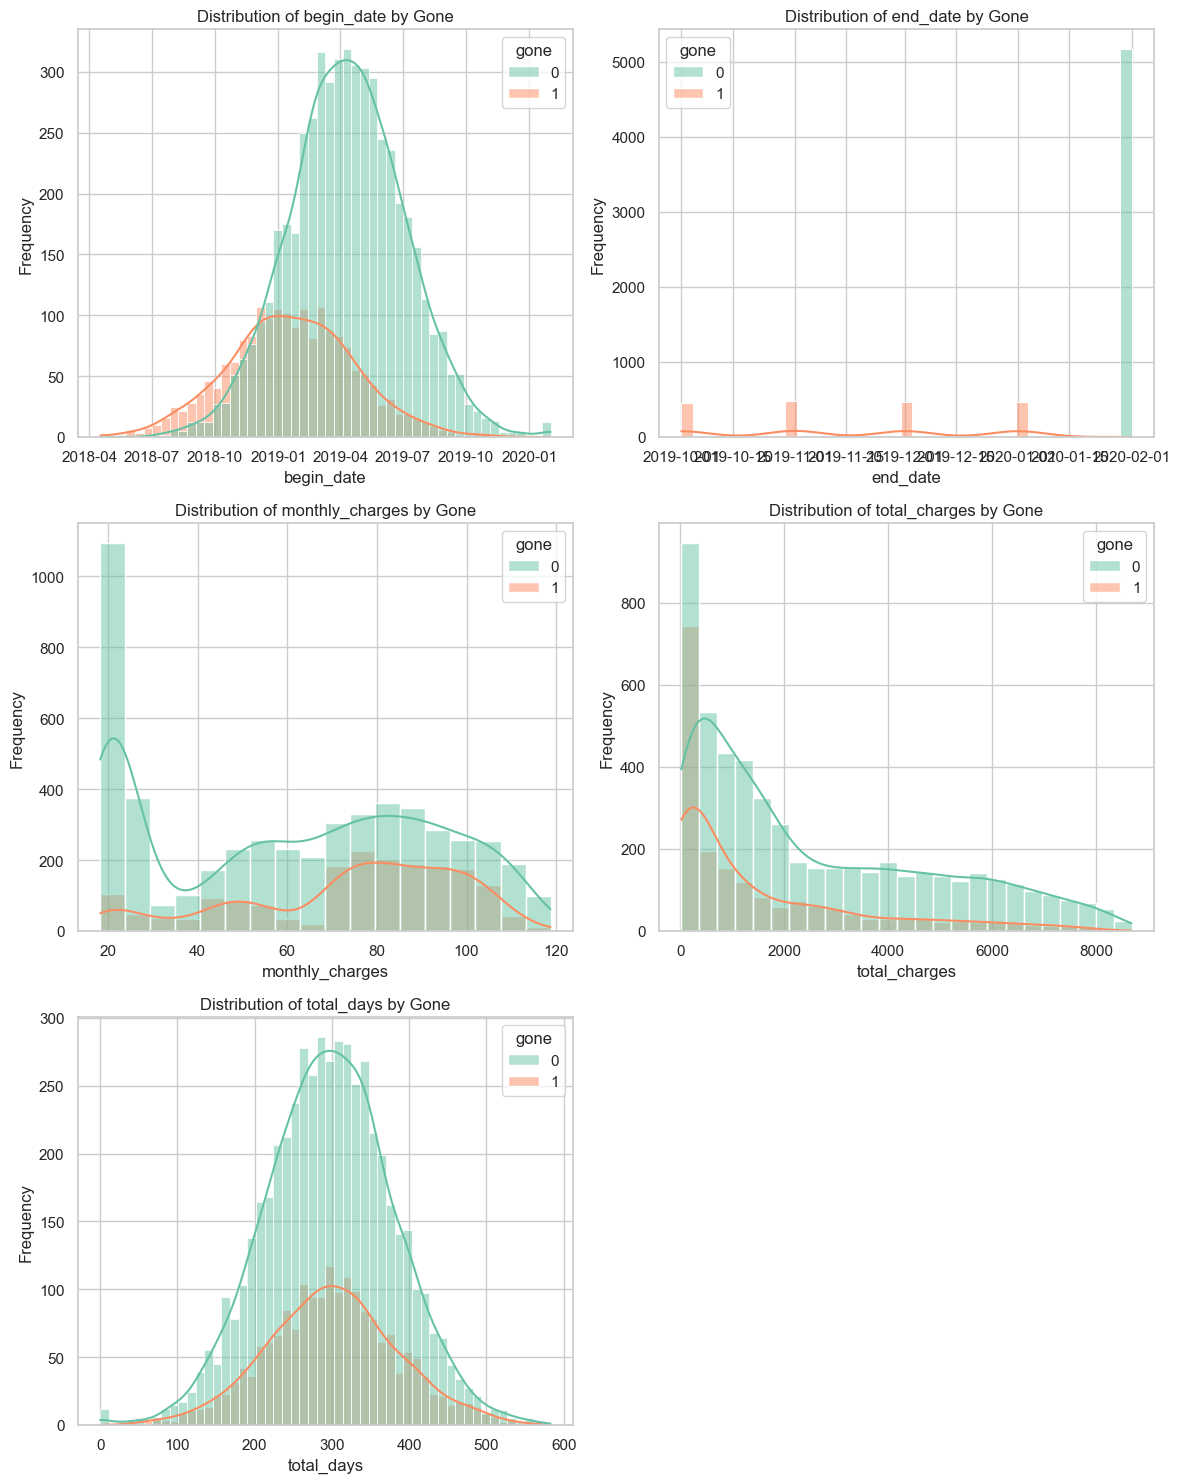

In [62]:
sns.set_palette("Set2")

# Создайте подграфики для каждого числового столбца в 2 колонки
num_cols = len(numeric_columns)
num_rows = (num_cols + 1) // 2  # Округление в большую сторону, чтобы вместить все числовые столбцы
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 15))
plt.subplots_adjust(hspace=0.5)

# Преобразуйте двумерный массив axes в одномерный для удобной итерации
axes = axes.flatten()

for idx, column in enumerate(numeric_columns):
    ax = axes[idx]

    # Разделите данные на две группы: "Gone" и "Not Gone" и постройте гистограмму для каждой группы
    sns.histplot(data=clients, x=column, hue='gone', kde=True, ax=ax, palette="Set2")

    ax.set_title(f'Distribution of {column} by Gone')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Удалите лишние пустые графики
for i in range(num_cols, num_rows * 2):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Наблюдения:
- Со временем вероятность отказа от услуг снижается, раньше отказывались больше. Вероятно, произошли изменения в качестве услуг, например.
- Обычно отказывались от услуг те, кто платил больше
- Текущие клиенты платят немного меньше в месяц, чем те, кто отказался
- Количество дней особо не влияет, распределение нормальное

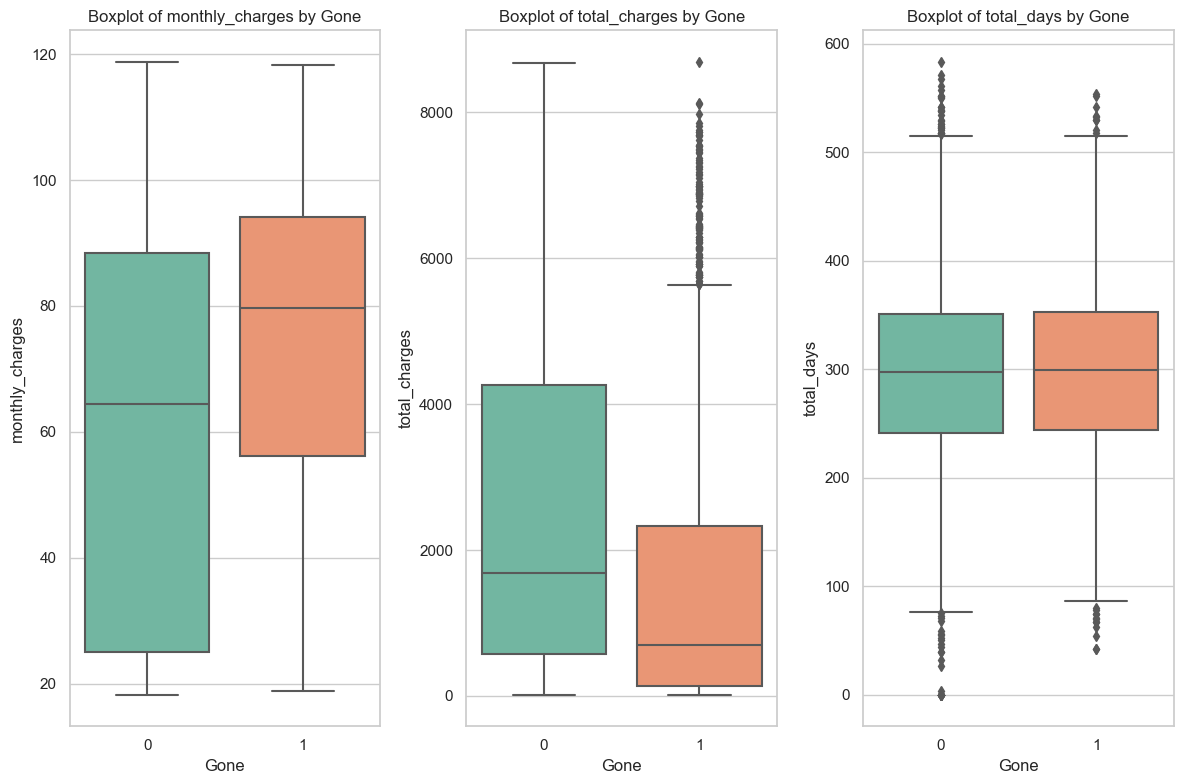

In [63]:
sns.set_palette("Set2")

num_cols = len(numeric_without_date)
num_rows = (num_cols + 2) // 3  # Округление в большую сторону, чтобы вместить все числовые столбцы
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)
axes = axes.flatten()

for idx, column in enumerate(numeric_without_date):
    ax = axes[idx]
    sns.boxplot(data=clients, x='gone', y=column, ax=ax, palette="Set2")
    ax.set_title(f'Boxplot of {column} by Gone')
    ax.set_xlabel('Gone')
    ax.set_ylabel(column)

# удаляем пустые графики
for i in range(num_cols, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Выбросы, конечно, есть. Но нам важно, что те, кто много платили тотал, скорее всего ушли от оператора. Так что не будем трогать. Рассмотррим матрицу корреляции признаков.

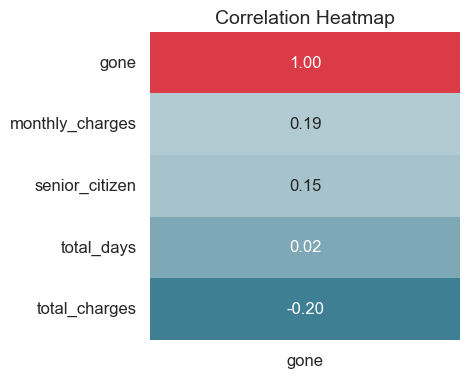

In [64]:
correlation = clients.corr()['gone'].sort_values(ascending=False)
plt.figure(figsize=(4, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # Красивая цветовая палитра
sns.heatmap(pd.DataFrame(correlation), annot=True, fmt=".2f", cmap=cmap, cbar=False)
plt.title("Correlation Heatmap", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Предварительные выводы:
- Чем выше общие затраты, тем меньше вероятность, что он уйдет. Необычное наблюдение
- Чем выше цена за услуги в месяц, тем больше вероятность, что клиент уйдет

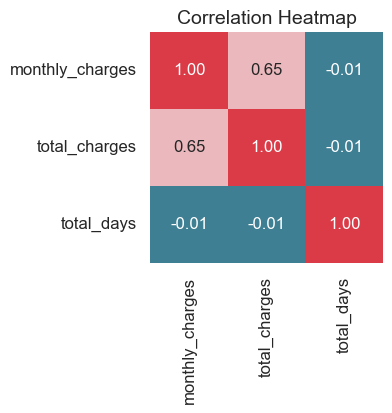

In [65]:
correlation_matrix = clients[numeric_columns].corr()

plt.figure(figsize=(3, 3))
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # Красивая цветовая палитра
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, cbar=False)
plt.title("Correlation Heatmap", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

У нас есть признаки мультиколлинеарности в total_charges и monthly_cahrges. Это и логично, чем больше месячный платёж, тем больше общие траты. Но у нас был явный всплеск оттока на высоких общих тратах. Поступим следующим образом. Разделим total_charges на количество дней, которые человек был клиентом. А колонку total_charges уберем. Так мы избавимся от мультиколлинеарности и переобучения, и получим красивый новый признак.

In [66]:
clients['charge_per_day'] = clients.apply(lambda row: row['total_charges'] if row['total_days'] == 0 else row['total_charges'] / row['total_days'], axis=1)
numeric_columns.append('charge_per_day')

In [67]:
#дальше мы начинаем удалять признаки, а копия датасета нам пригодится
clients_copy = clients.copy()

In [68]:
clients.drop(columns=['total_charges'], inplace=True)
numeric_columns.remove('total_charges')
numeric_without_date.remove('total_charges')

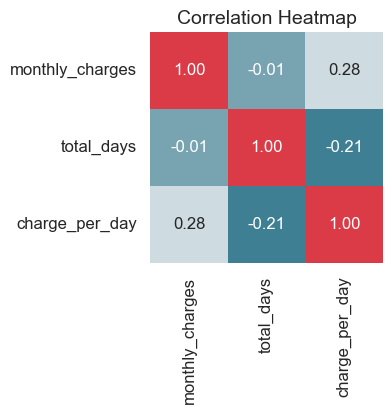

In [69]:
correlation_matrix = clients[numeric_columns].corr()

plt.figure(figsize=(3, 3))
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # Красивая цветовая палитра
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, cbar=False)
plt.title("Correlation Heatmap", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Проверим только charge_per_day на аномалии

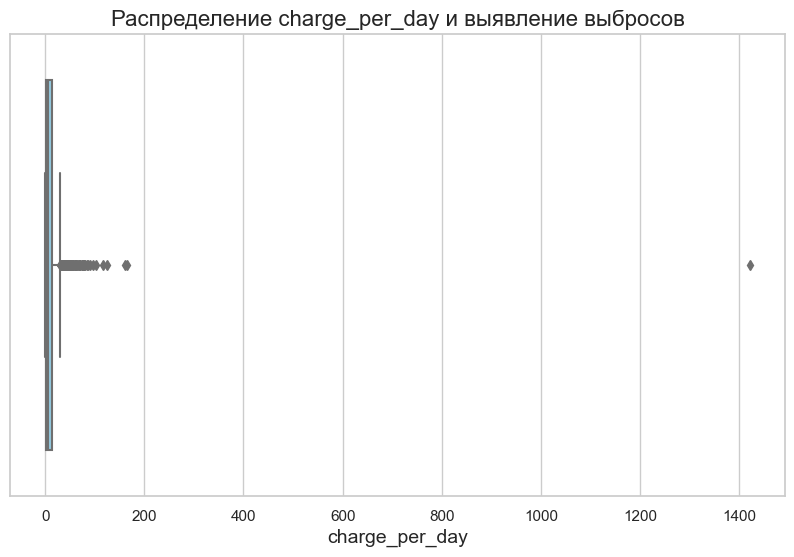

In [70]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='charge_per_day', data=clients, color='skyblue')
plt.xlabel('charge_per_day', fontsize=14)
plt.title('Распределение charge_per_day и выявление выбросов', fontsize=16)
plt.show()

Ну вот, теперь у нас и мультиколлинеарности нет, и количество признаков не потеряли.

In [71]:
clients[clients['charge_per_day'] > 500]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,gone,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,charge_per_day
customer_id,,,,,,,,,,,,,,,,,,,,,
9880-TDQAC,2020-01-29,2020-02-01,Two year,Yes,Electronic check,60.0,0,3,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,Yes,No,1421.333333


Есть одна запись, в которой человек лишь 2 дня как присоединился к оператору и уже заплатил за 2 года вперед. У него аномальный показатель суммы за день. С точки зрения логики всё окей. Но для модели это будет аномалией. Удалим-ка мы этого одного человека. Для нас это маленькая жертва, зато данные в модели будут более однородными.

In [72]:
clients = clients[clients['charge_per_day']<500]

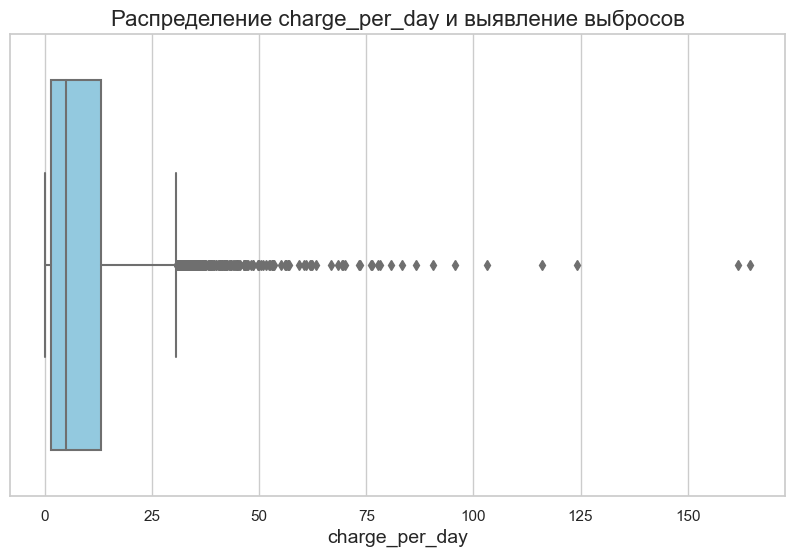

In [73]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='charge_per_day', data=clients, color='skyblue')
plt.xlabel('charge_per_day', fontsize=14)
plt.title('Распределение charge_per_day и выявление выбросов', fontsize=16)
plt.show()

Вот так-то сильно лучше!

In [74]:
clients.head(20)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,gone,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,charge_per_day
customer_id,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0,0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,52.550000
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0,0,Male,0,No,Yes,No,No,No,No,No,No,No,No,20.250000
3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,1,479,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0.225783
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0,0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,80.850000
9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,1,279,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0.543548
9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,1,310,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,2.646774
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0,0,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,25.750000
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0,0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,56.050000
7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,1,188,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,16.202394


## Подготовка данных для моделей ##

У нас есть некоторые категориальные данные, которые содержат бинарные значения. Закодируем-ка их 1 и 0, так проще. Пол и две линии трогать не будем, мы их удалим позже.

In [75]:
mapping = {'yes': 1, 'no': 0}
for i in ['paperless_billing',
          'partner',
          'dependents',
          'online_security',
          'online_backup',
          'device_protection',
          'tech_support',
          'streaming_tv',
          'streaming_movies']:
    clients[i] = clients[i].str.lower()
    clients[i] = clients[i].map(mapping)

In [76]:
clients.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,gone,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,charge_per_day
customer_id,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,0,0,Female,0,1,1,DSL,1,0,1,1,1,0,No,52.550000
3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,0,0,Male,0,0,1,No,0,0,0,0,0,0,No,20.250000
3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,1,Mailed check,53.85,1,479,Male,0,0,0,DSL,1,1,0,0,0,0,No,0.225783
5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,0,0,Female,0,1,1,DSL,1,1,1,0,1,1,No,80.850000
9237-HQITU,2019-01-26,2019-11-01,Month-to-month,1,Electronic check,70.70,1,279,Female,0,0,0,Fiber optic,0,0,0,0,0,0,No,0.543548


Для начала удалим признаки даты. Мы из них выявили параметр - сколько дней клиент был клиентом. А значит, начало и конец срока нам не так уж важны. Да, там есть некая зависимость с тем, что раньше отказов было больше. Но мы на этот фактор вообще не можем повлиять, поэтому избавимся.

In [77]:
clients.drop(['begin_date', 'end_date'], axis=1, inplace=True)

Ну и удалим колонки gender, multiple_lines, streaming_movies, streaming_tv, device_protection, online_backup, они оказывают минимальное влияние на решение об уходе.

In [78]:
clients.drop(['gender', 'multiple_lines', 'streaming_movies', 'streaming_tv', 'device_protection', 'online_backup'], axis=1, inplace=True)

In [79]:
clients.head()

,type,paperless_billing,payment_method,monthly_charges,gone,total_days,senior_citizen,partner,dependents,internet_service,online_security,tech_support,charge_per_day
customer_id,,,,,,,,,,,,,
4472-LVYGI,Two year,1,Bank transfer (automatic),52.55,0,0,0,1,1,DSL,1,1,52.550000
3115-CZMZD,Two year,0,Mailed check,20.25,0,0,0,0,1,No,0,0,20.250000
3668-QPYBK,Month-to-month,1,Mailed check,53.85,1,479,0,0,0,DSL,1,0,0.225783
5709-LVOEQ,Two year,0,Mailed check,80.85,0,0,0,1,1,DSL,1,0,80.850000
9237-HQITU,Month-to-month,1,Electronic check,70.70,1,279,0,0,0,Fiber optic,0,0,0.543548


Применим технику OHE (One-Hot Encoding), чтобы преобразовать категоральные признаки в численные.

In [80]:
#уберем из списка колонки, где только 1 и 0, их кодировать не надо
categorical_columns = ['type',
                       'payment_method',
                       'internet_service'
                       ]

numeric_columns = ['monthly_charges',
                   'total_days',
                   'charge_per_day'
                    ]

In [81]:
categorical_data = clients[categorical_columns]
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_data = encoder.fit_transform(categorical_data)
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns), index=clients.index)

clients_encoded = clients.drop(categorical_columns, axis=1)
clients_encoded = pd.concat([clients_encoded, encoded_df], axis=1)
clients_encoded.head()

,paperless_billing,monthly_charges,gone,total_days,senior_citizen,partner,dependents,online_security,tech_support,charge_per_day,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No
customer_id,,,,,,,,,,,,,,,,,
4472-LVYGI,1,52.55,0,0,0,1,1,1,1,52.550000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3115-CZMZD,0,20.25,0,0,0,0,1,0,0,20.250000,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3668-QPYBK,1,53.85,1,479,0,0,0,1,0,0.225783,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5709-LVOEQ,0,80.85,0,0,0,1,1,1,0,80.850000,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9237-HQITU,1,70.70,1,279,0,0,0,0,0,0.543548,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Вот теперь красиво. Выделим признаки для изучения и целевой.

In [82]:
target = clients_encoded['gone']
features = clients_encoded.drop(columns=['gone'])

In [83]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify = target)

In [84]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])

features_train = features_train.copy()
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])

features_test = features_test.copy()
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

In [85]:
features_train.head()

,paperless_billing,monthly_charges,total_days,senior_citizen,partner,dependents,online_security,tech_support,charge_per_day,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No
customer_id,,,,,,,,,,,,,,,,
9565-AXSMR,0,-1.516832,1.613257,0,1,1,0,0,-0.593666,0.0,1.0,0.0,0.0,1.0,0.0,1.0
7395-XWZOY,1,-0.323659,0.136214,0,0,0,1,1,-0.464619,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9070-BCKQP,1,1.514426,0.076171,0,1,0,1,1,1.684091,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1307-TVUFB,1,0.487898,0.172239,1,0,0,0,0,0.209128,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4662-EKDPQ,0,-0.088691,-0.284083,0,0,0,0,0,-0.788604,0.0,0.0,0.0,0.0,0.0,0.0,0.0


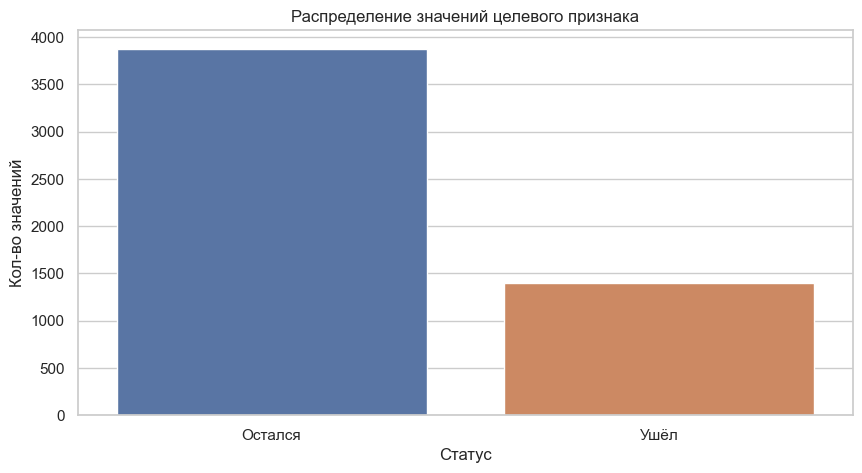

In [86]:
target_counts = target_train.value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=['Остался', 'Ушёл'], y=target_counts.values)
plt.title('Распределение значений целевого признака')
plt.xlabel('Статус')
plt.ylabel('Кол-во значений')
plt.show()

In [87]:
ratio = target_train[target_train == 1].count() / target_train[target_train == 0].count()
print(ratio)

0.3614333591131735


Есть явный дисбаланс классов целевого признака. Проведём сэмплирование, чтобы избавиться от этого.

In [88]:
def upsample(features, target, repeat):
    """
    The upsample function takes in a dataframe of features and a series of targets,
    and returns the same dataframe with the minority class (in this case, 1) repeated
    a number of times equal to repeat. The function then shuffles the resulting
    dataframe and returns it.

    :param features: Pass in the dataframe of features
    :param target: Select the rows that will be upsampled
    :param repeat: Determine how many times the minority class is repeated
    :return: The features and target variables with the upsampled data
    :doc-author: Trelent
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)

    return features_upsampled, target_upsampled

In [89]:
features_train, target_train = upsample(features_train, target_train, 3)
features_test, target_test = upsample(features_train, target_train, 3)

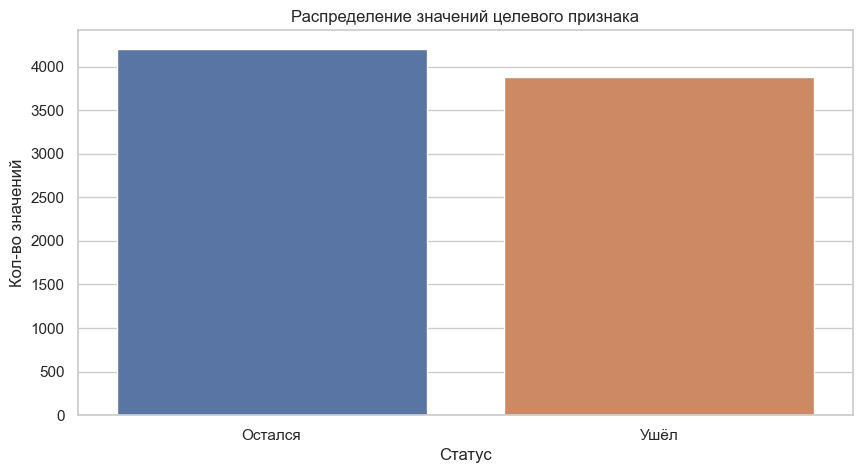

In [90]:
target_counts = target_train.value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=['Остался', 'Ушёл'], y=target_counts.values)
plt.title('Распределение значений целевого признака')
plt.xlabel('Статус')
plt.ylabel('Кол-во значений')
plt.show()

Теперь у нас сбалансированы классы у модели не будет недообучения и смещения модели. Можем переходить к моделям.

# Выбор и обучение моделей #

Я рассмотрю в этой работе 4 вида моделей для решения задачи классификации:
- Случайный лес,
- Логистическую регрессию (да, несмотря на название, это модель для классификации)
- Бустинг CatBoost,
- Нейронную сеть.

#### Случайный лес ####

In [91]:
%%time
#ожидание: около 1 минуты
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': [1, 'sqrt', 'log2', None],  # Updated max_features options
}

model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')

roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

search = GridSearchCV(model, param_grid, cv=cv, scoring=roc_auc_scorer, verbose=1)
search.fit(features_train, target_train)

# Вывод лучшего roc-auc и его параметров
best_roc_auc = search.best_score_
best_params = search.best_params_
print("Best ROC AUC:", best_roc_auc)
print("Best Parameters:", best_params)

# Сохранение модели с лучшими параметрами в best_forest_model
best_forest_model = search.best_estimator_

# Проведение кросс-валидации для получения ROC-AUC на каждом фолде
cv_scores = cross_val_score(best_forest_model, features_train, target_train, cv=cv, scoring=roc_auc_scorer)
print("ROC AUC на каждом фолде:", cv_scores)

# Вычисление и вывод среднего ROC AUC на всех фолдах
average_roc_auc = np.mean(cv_scores)
print("Средний ROC AUC на всех фолдах:", average_roc_auc)

# Создание таблицы с средним ROC AUC и вывод ее
results = pd.DataFrame({'ROC-AUC': [average_roc_auc]}, index=['RandomForest'])  # Устанавливаем индекс
print(results)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best ROC AUC: 0.8343690594704901
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
ROC AUC на каждом фолде: [0.83319056 0.83224668 0.83333921 0.82139574 0.85167311]
Средний ROC AUC на всех фолдах: 0.8343690594704901
               ROC-AUC
RandomForest  0.834369
CPU times: user 1min 4s, sys: 18.2 s, total: 1min 22s
Wall time: 1min 30s


Ну что ж, получили неплохую метрику 0.83. Посмотрим, что нам дадут другие модели.

#### Логистическая регрессия ####

In [92]:
%%time
#Время ожидания: 2 минуты
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, n_jobs=1, class_weight='balanced')
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)  # Используем StratifiedKFold

search = GridSearchCV(model, param_grid, cv=cv, scoring=roc_auc_scorer, verbose=1)
search.fit(features_train, target_train)

best_roc_auc = search.best_score_
best_params = search.best_params_
print("Best ROC AUC:", best_roc_auc)
print("Best Parameters:", best_params)

best_lr_model = search.best_estimator_  # Сохраняем лучшую модель

cv_scores = cross_val_score(best_lr_model, features_train, target_train, cv=cv, scoring=roc_auc_scorer)
print("ROC AUC на каждом фолде:", cv_scores)
print("Средний ROC AUC на всех фолдах:", np.mean(cv_scores))

# Добавление результатов Logistic Regression в таблицу results
results.loc['LogisticRegression'] = np.mean(cv_scores)

# Вывод обновленной таблицы results
display(results)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best ROC AUC: 0.7532372471638348
Best Parameters: {'C': 0.1, 'fit_intercept': False, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
ROC AUC на каждом фолде: [0.7560072  0.74810991 0.75742627 0.74984371 0.75479915]
Средний ROC AUC на всех фолдах: 0.7532372471638348


,ROC-AUC
RandomForest,0.834369
LogisticRegression,0.753237


CPU times: user 18.3 s, sys: 41 s, total: 59.2 s
Wall time: 7.52 s


Логистическая регрессия даёт нам результаты даже похуже. Однако, кажется, без переобучения. Посмотрим градиентный бустинг.

### Градиентный бустинг CatBoost ###

In [93]:
%%time
#Время ожидания: 1.5 минуты

param_grid = {
    'iterations': [100, 200],
    'depth': [4, 8, 16],
    'learning_rate': [0.01, 0.1]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=1)

roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

cv = 5  # Количество фолдов
search = GridSearchCV(model, param_grid, cv=cv, scoring=roc_auc_scorer, verbose=1)
search.fit(features_train, target_train)

best_roc_auc = search.best_score_
best_params = search.best_params_
print("Best ROC AUC:", best_roc_auc)
print("Best Parameters:", best_params)

best_catboost_model = search.best_estimator_

cv_scores = cross_val_score(best_catboost_model, features_train, target_train, cv=cv, scoring=roc_auc_scorer)
print("ROC AUC на каждом фолде:", cv_scores)
print("Средний ROC AUC на всех фолдах:", np.mean(cv_scores))

# Добавление результатов Logistic Regression в таблицу results
results.loc['CatBoost'] = np.mean(cv_scores)

# Вывод обновленной таблицы results
display(results)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 0.6900206	total: 59.7ms	remaining: 5.91s
1:	learn: 0.6869079	total: 75.7ms	remaining: 3.71s
2:	learn: 0.6840816	total: 108ms	remaining: 3.51s
3:	learn: 0.6812028	total: 135ms	remaining: 3.24s
4:	learn: 0.6783620	total: 178ms	remaining: 3.38s
5:	learn: 0.6754966	total: 187ms	remaining: 2.93s
6:	learn: 0.6727695	total: 215ms	remaining: 2.85s
7:	learn: 0.6700400	total: 234ms	remaining: 2.69s
8:	learn: 0.6671539	total: 244ms	remaining: 2.47s
9:	learn: 0.6646019	total: 254ms	remaining: 2.28s
10:	learn: 0.6618493	total: 256ms	remaining: 2.08s
11:	learn: 0.6595991	total: 267ms	remaining: 1.95s
12:	learn: 0.6569951	total: 276ms	remaining: 1.85s
13:	learn: 0.6545775	total: 286ms	remaining: 1.76s
14:	learn: 0.6521477	total: 296ms	remaining: 1.68s
15:	learn: 0.6496541	total: 306ms	remaining: 1.6s
16:	learn: 0.6471888	total: 316ms	remaining: 1.54s
17:	learn: 0.6446344	total: 326ms	remaining: 1.48s
18:	learn: 0.6422984	total: 336

/Users/kuuuzya/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kuuuzya/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kuuuzya/miniconda3/lib/python3.10/site-packages/catboost/core.py", line 5131, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/kuuuzya/miniconda3/lib/python3.

8:	learn: 0.4770629	total: 91.5ms	remaining: 1.94s
9:	learn: 0.4659797	total: 102ms	remaining: 1.94s
10:	learn: 0.4560921	total: 114ms	remaining: 1.96s
11:	learn: 0.4467711	total: 126ms	remaining: 1.97s
12:	learn: 0.4377579	total: 137ms	remaining: 1.97s
13:	learn: 0.4323281	total: 149ms	remaining: 1.97s
14:	learn: 0.4276826	total: 160ms	remaining: 1.98s
15:	learn: 0.4205368	total: 171ms	remaining: 1.97s
16:	learn: 0.4158171	total: 183ms	remaining: 1.97s
17:	learn: 0.4117479	total: 194ms	remaining: 1.96s
18:	learn: 0.4079894	total: 205ms	remaining: 1.95s
19:	learn: 0.4033219	total: 216ms	remaining: 1.94s
20:	learn: 0.4002104	total: 227ms	remaining: 1.94s
21:	learn: 0.3955023	total: 238ms	remaining: 1.93s
22:	learn: 0.3906674	total: 250ms	remaining: 1.92s
23:	learn: 0.3873775	total: 261ms	remaining: 1.91s
24:	learn: 0.3848722	total: 272ms	remaining: 1.9s
25:	learn: 0.3812612	total: 283ms	remaining: 1.9s
26:	learn: 0.3771038	total: 294ms	remaining: 1.89s
27:	learn: 0.3755517	total: 306ms	

,ROC-AUC
RandomForest,0.834369
LogisticRegression,0.753237
CatBoost,0.887846


CPU times: user 1min 13s, sys: 16.5 s, total: 1min 29s
Wall time: 44.6 s


Ну что ж, пока CatBoost ожидаемо показывает себя лучше всего. Посмотрим, что будет у нейронной сети.

### Нейронная сеть ###

In [94]:
%%time

def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=features_train.shape[1]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

n_splits = 5  # Количество фолдов для кросс-валидации
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

roc_auc_scores = []  # Сюда будем сохранять ROC-AUC для каждого фолда


for train_index, val_index in cv.split(features_train, target_train):
    X_train, X_val = features_train.iloc[train_index], features_train.iloc[val_index]
    y_train, y_val = target_train.iloc[train_index], target_train.iloc[val_index]

    model_nn = create_model()

    model_nn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

    y_pred = model_nn.predict(X_val)

    roc_auc = roc_auc_score(y_val, y_pred)
    roc_auc_scores.append(roc_auc)

# Добавление результатов Logistic Regression в таблицу results
results.loc['Neural Network'] = np.mean(roc_auc_scores)
# Вывод обновленной таблицы results
display(results)

Epoch 1/100
203/203 [==============================] - 0s 590us/step - loss: 0.5549
Epoch 2/100
203/203 [==============================] - 0s 579us/step - loss: 0.4958
Epoch 3/100
203/203 [==============================] - 0s 584us/step - loss: 0.4893
Epoch 4/100
203/203 [==============================] - 0s 586us/step - loss: 0.4807
Epoch 5/100
203/203 [==============================] - 0s 574us/step - loss: 0.4753
Epoch 6/100
203/203 [==============================] - 0s 574us/step - loss: 0.4724
Epoch 7/100
203/203 [==============================] - 0s 578us/step - loss: 0.4685
Epoch 8/100
203/203 [==============================] - 0s 576us/step - loss: 0.4622
Epoch 9/100
203/203 [==============================] - 0s 572us/step - loss: 0.4571
Epoch 10/100
203/203 [==============================] - 0s 615us/step - loss: 0.4571
Epoch 11/100
203/203 [==============================] - 0s 575us/step - loss: 0.4505
Epoch 12/100
203/203 [==============================] - 0s 573us/step - lo

,ROC-AUC
RandomForest,0.834369
LogisticRegression,0.753237
CatBoost,0.887846
Neural Network,0.885507


CPU times: user 1min 12s, sys: 33.9 s, total: 1min 46s
Wall time: 1min 1s


При учёте, что нейронная сеть и CatBoost дают почти одинаковые значения, но у CatBoost показатели чуть-чуть больше, я выбираю его как итоговую модель.

In [95]:
best_model = best_catboost_model

# Тестирование лучшей модели и выводы #

## Тестирование CatBoost ##

Проверим, правильный ли выбор я сделал. Посмотрим на roc-auc в тестовом наборе данных.

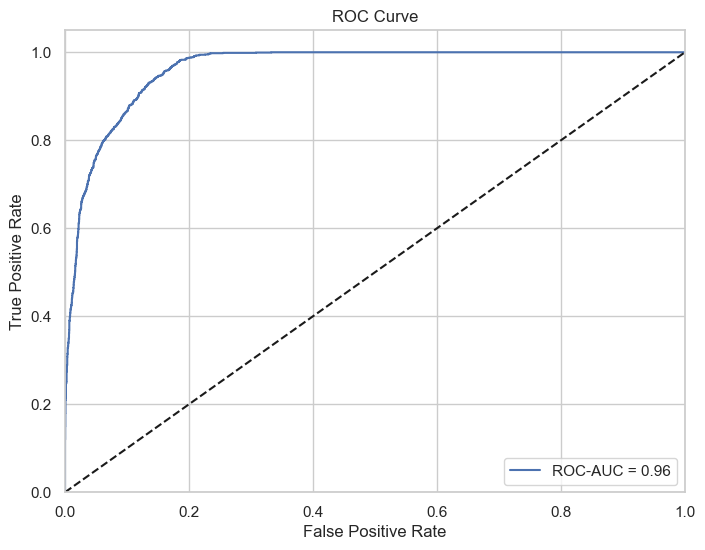

ROC-AUC на тестовых данных: 0.9633461975103514


In [96]:
# Предсказание вероятностей классов
predicted_probs = best_forest_model.predict_proba(features_test)[:, 1]

# Вычисление ROC-AUC
roc_auc = roc_auc_score(target_test, predicted_probs)

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_test, predicted_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC на тестовых данных:", roc_auc)

Отлично! Мы добились результата ROC-AUC = 0.96, по заданию нужно не менее 0.85. Значит, модель выбрана правильно и всё хорошо. А странно. Был уверен, что у случайного леса переобучение (но я проверил, нейронная сеть выдаёт значения меньше).

In [97]:
# Предсказание классов
predicted_classes = best_forest_model.predict(features_test)

# Вычисление точности
accuracy = accuracy_score(target_test, predicted_classes)
print("Точность модели:", accuracy)

Точность модели: 0.9250166696975207


Очень неплохой результат. Значение 0.96 для ROC-AUC говорит о том, что наша модель обладает хорошей способностью различать между классами. Она достаточно надежна для прогнозирования. Значение 0.91 для точности говорит о том, что наша модель правильно классифицировала около 92% всех примеров в наборе данных. При учёте, что у нас сбалансированы были классы, это очень и очень хороший результат, на мой взгляд.

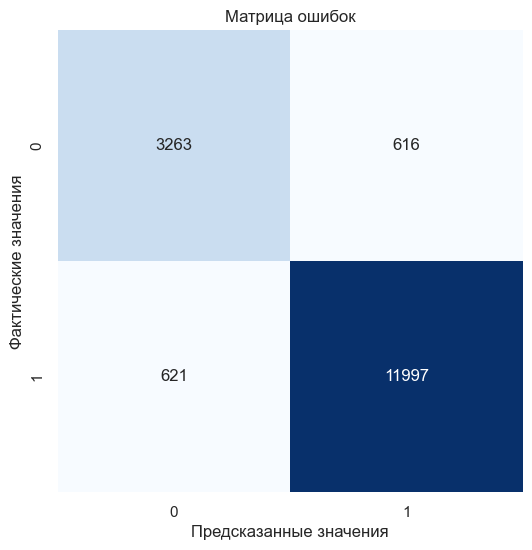

Полнота модели: 0.8411961845836555
Точность модели: 0.8401132852729145


In [98]:
# Вычисление матрицы ошибок
conf_matrix = confusion_matrix(target_test, predicted_classes)

# Отображение матрицы ошибок с использованием seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.title('Матрица ошибок')
plt.show()

# Вычисление полноты и точности
tp, fn, fp, tn = conf_matrix.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("Полнота модели:", recall)
print("Точность модели:", precision)

Отлично. У нас модель получилась и полная, и точная. То есть, она одинаково точно предсказывает как то, что человек уйдёт, так и то, что он останется. Это замечательно. Посмотрим, какие же признаки влияют больше всего на это.

In [99]:
# Получение важности признаков из модели
feature_importances = best_forest_model.feature_importances_

# Создание DataFrame с именами признаков и их важностью
feature_importance_df = pd.DataFrame({'Feature': features_train.columns, 'Importance': feature_importances})

# Сортировка признаков по важности в убывающем порядке
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Вывод топ-10 наиболее важных признаков
top_features = feature_importance_df.head(10)
print("Топ-10 важных признаков:")
print(top_features)

Топ-10 важных признаков:
                            Feature  Importance
10                    type_Two year    0.222110
8                    charge_per_day    0.193886
1                   monthly_charges    0.143345
9                     type_One year    0.134854
2                        total_days    0.109190
14     internet_service_Fiber optic    0.076120
15              internet_service_No    0.021435
12  payment_method_Electronic check    0.017961
0                 paperless_billing    0.014605
6                   online_security    0.013859


Удивительно, но на то, уйдёт человек или нет, больше всего влияет то, заключил ли он договор на 2 года =) Ну это как бы и логично, конечно. Если уже оплатил за 2 года, то куда он денется. На втором месте сумма услуг в день (среднее, поделили тотал на количество дней). Посмотрим на зависимости.

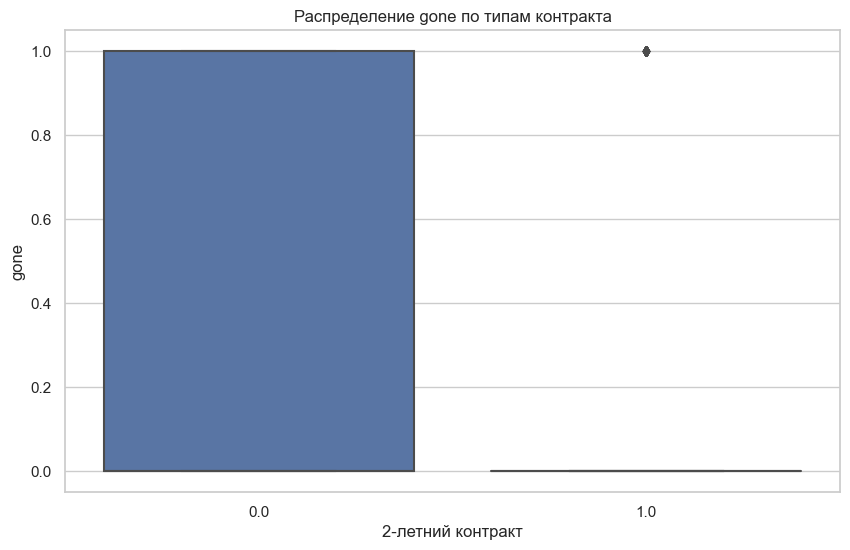

In [100]:
# Создайте ящик с усами
plt.figure(figsize=(10, 6))
sns.boxplot(x='type_Two year', y='gone', data=clients_encoded)
plt.title('Распределение gone по типам контракта')
plt.xlabel('2-летний контракт')
plt.ylabel('gone')
plt.show()

In [101]:
clients_encoded[(clients_encoded['type_Two year'] == 1)]

,paperless_billing,monthly_charges,gone,total_days,senior_citizen,partner,dependents,online_security,tech_support,charge_per_day,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No
customer_id,,,,,,,,,,,,,,,,,
4472-LVYGI,1,52.55,0,0,0,1,1,1,1,52.550000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3115-CZMZD,0,20.25,0,0,0,0,1,0,0,20.250000,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5709-LVOEQ,0,80.85,0,0,0,1,1,1,0,80.850000,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4367-NUYAO,0,25.75,0,0,0,1,1,0,0,25.750000,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1371-DWPAZ,0,56.05,0,0,0,1,1,1,1,56.050000,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807-IZYOZ,0,20.65,0,406,0,0,0,0,0,2.514163,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9710-NJERN,0,20.15,0,284,0,0,0,0,0,2.908451,0.0,1.0,0.0,0.0,1.0,0.0,1.0
9281-CEDRU,0,64.10,0,371,0,1,0,0,1,11.661051,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [102]:
print(f"Ушли {clients_encoded[(clients_encoded['type_Two year'] == 1) & (clients_encoded['gone'] == 1)].shape[0]} абонентов из {clients_encoded[(clients_encoded['type_Two year'] == 1)].shape[0]}, у которых были 2-летние контракты. Это составляет {round(100*clients_encoded[(clients_encoded['type_Two year'] == 1) & (clients_encoded['gone'] == 1)].shape[0]/clients_encoded[(clients_encoded['type_Two year'] == 1)].shape[0],2)}%.")

Ушли 48 абонентов из 1694, у которых были 2-летние контракты. Это составляет 2.83%.


In [103]:
clients_encoded[(clients_encoded['type_Two year'] == 1) & (clients_encoded['total_days'] > 366)]

,paperless_billing,monthly_charges,gone,total_days,senior_citizen,partner,dependents,online_security,tech_support,charge_per_day,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No
customer_id,,,,,,,,,,,,,,,,,
3192-NQECA,1,110.00,1,437,0,1,0,0,1,17.418421,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2834-JRTUA,1,108.05,1,394,0,0,0,1,1,19.117132,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1106-HRLKZ,0,19.60,0,369,0,1,1,0,0,2.192276,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5440-FLBQG,1,108.40,1,388,1,1,0,0,1,18.861340,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5236-PERKL,1,112.95,1,412,0,0,0,1,0,15.691748,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9586-JGQKH,1,105.40,0,438,0,1,0,0,1,15.513128,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6691-CCIHA,1,84.95,0,459,0,1,0,1,1,11.221242,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4807-IZYOZ,0,20.65,0,406,0,0,0,0,0,2.514163,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [104]:
clients_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 4472-LVYGI to 3186-AJIEK
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gone               7043 non-null   int64         
 8   total_days         7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14

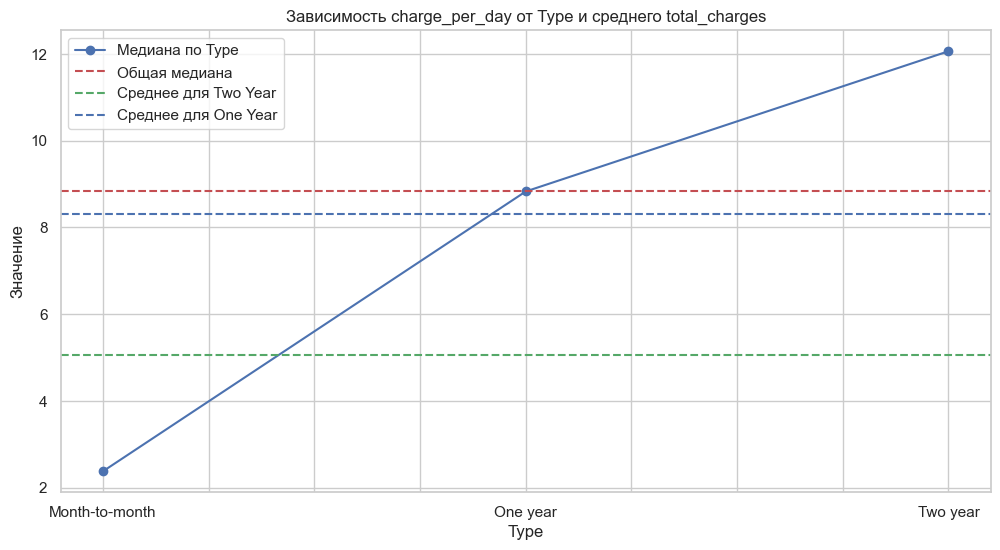

In [105]:
# Группируем данные по значению признака "Type" и вычисляем медиану
grouped = clients_copy.groupby('type')['charge_per_day'].median()

# Вычисляем среднее арифметическое total_charges для Type_Two Year и Type_One Year
average_total_charges_two_year = clients_copy[clients_copy['type'] == 'Two year']['total_charges'].mean() / (366 * 2)
average_total_charges_one_year = clients_copy[clients_copy['type'] == 'One year']['total_charges'].mean() / 365

# Создаем линейчатый график для каждой категории
plt.figure(figsize=(12, 6))
grouped.plot(kind='line', marker='o', legend=True, label='Медиана по Type')
plt.axhline(y=grouped.median(), color='r', linestyle='--', label='Общая медиана')
plt.axhline(y=average_total_charges_two_year, color='g', linestyle='--', label='Среднее для Two Year')
plt.axhline(y=average_total_charges_one_year, color='b', linestyle='--', label='Среднее для One Year')
plt.title('Зависимость charge_per_day от Type и среднего total_charges')
plt.xlabel('Type')
plt.ylabel('Значение')
plt.legend()
plt.show()

Ну, в общем-то, всё очевидно. Действительно, этот параметр отлично влияет на то, чтобы клиенты не уходили. Однако, ещё не прошло у этих клиентов 2 года с начала их действия договора. Дальше у них сумма будет снижаться и это хорошо.

## Итоговые выводы ##

В данной работе мы подключились к серверу, скачали нужные таблицы, провели их предобработку и анализ, убрали лишние аномалии, убрали лишние признаки, которые ни на что не влияют. После чего провели обучение 4 моделей и сравнили результаты по метрике ROC-AUC (которая учитывает и полноту, и точность моделей). В результате была выбрана модель Градиентного бустинга CatBoost, которая показала наилучшие результаты на тренировочной выборке методом кросс-валидации. Проверив на тестовых данных, я убедился, что эта модель выдаёт очень хорошие результаты.

Значение 0.96 для ROC-AUC на тесте говорит о том, что наша модель обладает хорошей способностью различать между классами. Она достаточно надежна для прогнозирования. Значение 0.92 для точности говорит о том, что наша модель правильно классифицировала около 92% всех примеров в наборе данных. При учёте, что у нас сбалансированы были классы, это очень и очень хороший результат, на мой взгляд.

Полнота и точность модели равны 0.84. Значит, у нас модель получилась и полная, и точная. То есть, она одинаково точно предсказывает как то, что человек уйдёт, так и то, что он останется. Это замечательно.

Больше всего на работу модели влияет признак Тип договора: 2 года, то есть, человек уходит в 2.83% случаев, если заключил договор и оплатил его за 2 года вперед. Тут, конечно, есть когнитивное искажение, т.к. большинство этих людей только подключили себе тариф и 2 года с даты старта точно будут клиентами. Второй по важности признак - это стоимость в сутки, то есть, средняя цена за 1 день.

Поэтому, мои рекомендации для бизнеса будут следующими:
1. Собрать больше данных. Выборка из 7000 довольно мала для анализа. Хорошо бы увеличить её раза в 2. При учете, что на дворе 2023 год. а мы используем данные за 2020, эти 3 года даты нам очень бы помогли.
2. Обогатить данные. Слишком много демографических признаков, которые оказались не очень важны. Но помогли бы такие признаки как "Как часто человек пользуется обещанным платежом", "Были ли просрочки оплаты" и т.п., т.к. анализ показал, что основное, из-за чего уходят люди — это деньги.
3. Это лишь гипотеза, которая не подтверждается моделью, т.к. у нас нет столько данных. Но вероятно, если предлагать людям оплатить контракт на 2 года и сделать эту стоимость ниже, чтобы средняя цена в сутки была ниже, чем на месячных тарифах (а это так и есть судя по графику), то люди будут минимум оставаться на эти 2 года абонентами и таким образом можно увеличить MAU.